In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ==========================
# This is to run the base model
# ==========================

import sys
sys.path.append('./..')
sys.path.append('./../..')
import pandas as pd
import yaml
from torch import FloatTensor as FT
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
from utils import *
from tqdm import tqdm
import torch
from pprint import pprint
try:
    from .data_fetcher import data_fetcher
except:
    from data_fetcher import data_fetcher
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM
    
    
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Current device  >>  cuda
Current device  >>  cuda
Current device  >>  cuda


In [3]:
# ============================
#  create config for DAGMM_base
# ============================

def create_config(
        data_set
):
    # Should return :
    # data_dict
    # meta_data_df [column, dimension]

    config_file = 'architecture_config.yaml'

    with open(config_file, 'r') as fh:
        config = yaml.safe_load(fh)

    data_dict, meta_data_df = data_fetcher.get_data(data_set, one_hot=True, anomaly_ratio=0.1)

    # discrete_columns : { column_name : num_categories }
    discrete_column_dims = {
        k: v for k, v in
        zip(list(meta_data_df['column']), list(meta_data_df['dimension']))
    }

    num_discrete_columns = 0
    for column,dim in discrete_column_dims.items():
        if dim == 2:
            num_discrete_columns+=1
        else:
            num_discrete_columns+= dim
            
    num_real_columns = len(data_dict['train'].columns) - num_discrete_columns
    print('Num real columns :: ', num_real_columns)
    print('Num discrete columns ::', num_discrete_columns)
    
    latent_dim = config[data_set]['ae_latent_dimension']

    encoder_structure_config = {}
    encoder_structure_config['discrete_column_dims'] = discrete_column_dims
    encoder_structure_config['num_discrete'] = num_discrete_columns
    encoder_structure_config['num_real'] = num_real_columns
    encoder_structure_config['encoder_layers'] = {
        'activation': config[data_set]['encoder_layers']['activation'],
        'layer_dims': config[data_set]['encoder_layers']['layer_dims'] + [latent_dim]
    }

    # ======================================================
    # Set decoder structure
    # =========

    decoder_structure_config = {}
    final_op_dims = num_real_columns 
    for k,v in discrete_column_dims.items():
        if v == 2:
            v = 1
        final_op_dims +=  v
        
    decoder_structure_config['discrete_column_dims'] = discrete_column_dims
    decoder_structure_config['num_discrete'] = num_discrete_columns
    decoder_structure_config['num_real'] = num_real_columns
    decoder_structure_config['decoder_layers'] = {
        'activation': config[data_set]['decoder_layers']['activation'],
        'layer_dims': [latent_dim] + config[data_set]['decoder_layers']['layer_dims'] + [final_op_dims]
    }
    decoder_structure_config['final_output_dim'] = final_op_dims

    # =====================
    # GMM
    # =====================
    gmm_input_dims = latent_dim + 2
    activation = config[data_set]['gmm']['FC_layer']['activation']
    num_components = config[data_set]['gmm']['num_components']
    FC_layer_dims = [gmm_input_dims] + config[data_set]['gmm']['FC_layer']['dims'] + [num_components]
    FC_dropout = config[data_set]['gmm']['FC_dropout']
    gmm_structure_config = {
        'num_components': num_components,
        'FC_layer_dims': FC_layer_dims,
        'FC_dropout': FC_dropout,
        'FC_activation': activation

    }
    loss_structure_config = []

    for column, dim in discrete_column_dims.items():
        loss_structure_config.append(
            {
                'dim': dim,
                'type': 'onehot'
            }
        )
    loss_structure_config.append(
        {
            'dim': num_real_columns,
            'type': 'real'
        }
    )

    return encoder_structure_config, decoder_structure_config, gmm_structure_config, loss_structure_config, latent_dim


In [4]:
def train(
        dagmm_obj,
        data,
        num_epochs,
        batch_size=256,
        LR=0.05
):
    optimizer = torch.optim.Adam(dagmm_obj.parameters(), lr=LR)
    dagmm_obj.train()
    log_interval = 50
    for epoch in tqdm(range(num_epochs)):
        num_batches = data.shape[0] // batch_size + 1
        epoch_losses = []
        np.random.shuffle(data)
        X = FT(data).to(DEVICE)
        lambda_energy = 0.1
        lambda_cov_diag = 0.005
        for b in range(num_batches):
            optimizer.zero_grad()
            input_data = X[b * batch_size: (b + 1) * batch_size]
            enc, dec, z, gamma = dagmm_obj(input_data)
            total_loss, sample_energy, recon_error, cov_diag = dagmm_obj.loss_function(
                input_data, dec, z, gamma,
                lambda_energy,
                lambda_cov_diag
            )

#             dagmm_obj.zero_grad()
            total_loss = Variable(total_loss, requires_grad=True)
            total_loss.backward()
            epoch_losses.append(total_loss.cpu().data.numpy())
            torch.nn.utils.clip_grad_norm_(dagmm_obj.parameters(), 1)
            optimizer.step()

            loss = {}
            loss['total_loss'] = total_loss.data.item()
            loss['sample_energy'] = sample_energy.item()
            loss['recon_error'] = recon_error.item()
            loss['cov_diag'] = cov_diag.item()

            if (b + 1) % log_interval == 0:
                log = ' '
                for tag, value in loss.items():
                    log += ", {}: {:.4f}".format(tag, value)
                print(log)
        print('Epoch loss ::', np.mean(epoch_losses))
    return dagmm_obj

# =================================== #

def test(
    dagmm_obj,
    data_dict
):
    global DEVICE
    print("======================TEST MODE======================")
    dagmm_obj.eval()
    N = 0
    mu_sum = 0
    cov_sum = 0
    gamma_sum = 0

    train_X = data_dict['train'].values
    batch_size = 512
    num_batches = train_X.shape[0]//batch_size + 1
    for b in range(num_batches):
        input_data = train_X[b * batch_size: (b + 1) * batch_size]
        input_data = FT(input_data).to(DEVICE)
        enc, dec, z, gamma = dagmm_obj(input_data)
        phi, mu, cov = dagmm_obj.compute_gmm_params(z, gamma)
        batch_gamma_sum = torch.sum(gamma, dim=0)
        gamma_sum += batch_gamma_sum
        mu_sum += mu * batch_gamma_sum.unsqueeze(-1)  # keep sums of the numerator only
        cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1)  # keep sums of the numerator only
        N += input_data.size(0)


    train_phi = gamma_sum / N
    train_mu = mu_sum / gamma_sum.unsqueeze(-1)
    train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

    print("N:", N)
    print("phi :", train_phi)
    print("mu : ", train_mu)
    print("covariance :", train_cov)

    # ============================ #
    # Get sample energy for test set
    # ============================ #
    test_energy = []
    train_labels = []
    train_z = []

    test_X = data_dict['test'].values
    num_batches = test_X.shape[0] // batch_size + 1
    print('Size of test ', test_X.shape[0])
    for b in range(num_batches):
        input_data = test_X[b * batch_size: (b + 1) * batch_size]
        input_data = FT(input_data).to(DEVICE)
        enc, dec, z, gamma = dagmm_obj(input_data)
        sample_energy, cov_diag = dagmm_obj.compute_energy(
            z,
            phi=train_phi,
            mu=train_mu,
            cov=train_cov,
            size_average=False
        )
        test_energy.append(sample_energy.data.cpu().numpy())
        # train_z.append(z.data.cpu().numpy())
        # train_labels.append(labels.numpy())

    test_energy = np.concatenate(test_energy, axis=0)
    print('test_energy',test_energy.shape)
    
    test_labels = [0 for _ in range(test_X.shape[0])]
    auc_list = []
    # ===========
    # Get per sample energy of the anomalies
    # ===========
    for key in ['anom_1','anom_2','anom_3']:
        anom_X = data_dict[key].values
        anom_labels = [1 for _ in range(anom_X.shape[0])]
        anom_energy = []
        num_batches = anom_X.shape[0] // batch_size + 1

        for b in range(num_batches):
            input_data = anom_X[b * batch_size: (b + 1) * batch_size]
            input_data = FT(input_data).to(DEVICE)
            enc, dec, z, gamma = dagmm_obj(input_data)
            sample_energy, cov_diag = dagmm_obj.compute_energy(
                z,
                phi=train_phi,
                mu=train_mu,
                cov=train_cov,
                size_average=False
            )
            anom_energy.append(sample_energy.data.cpu().numpy())

        anom_energy = np.concatenate(anom_energy,axis=0)
        print(anom_energy.shape)
        combined_energy = np.concatenate([anom_energy, test_energy], axis=0)
        combined_labels = np.concatenate([anom_labels, test_labels], axis=0)
        print(
            combined_energy.shape,
            combined_labels.shape
        )
        res_data = []
        for i,j in zip(combined_energy, combined_labels):
            res_data.append((i,j))
        res_df = pd.DataFrame(res_data, columns=['score','label'] )
        #  Normalize values
        def _normalize_(val, _min,_max):
            return (val -_min)/(_max - _min)

        _max = max(combined_energy)
        _min = min(combined_energy)

        res_df['score'] = res_df['score'].parallel_apply(
            _normalize_,
            args=(_min,_max, )
        )

        res_df = res_df.sort_values(by=['score'],ascending= False)
        _max = max(res_df['score'])
        _min = min(res_df['score'])
        step = (_max - _min)/ 100

        # Vary the threshold
        thresh = _max - step
        num_anomalies = anom_X.shape[0]
        P = []
        R = [0]

        while thresh > _min:

            sel = res_df.loc[res_df['score'] >= thresh]
            if len(sel) == 0 :
                thresh -= step
                continue
            correct = sel.loc[sel['label'] == 1 ]
            prec = len(correct)/ len(sel)
            rec = len(correct)/num_anomalies
            P.append(prec)
            R.append(rec)
            thresh -= step
        P = [P[0]] + P
        from sklearn.metrics import auc
        pr_auc = auc(R, P)
        auc_list.append(pr_auc)

        print("AUC : {:0.4f} ".format(pr_auc))
        try:
            plt.figure()
            plt.title('PR Curve' + str(pr_auc))
            plt.plot(R, P)
            plt.show()
        except:
            pass
    print(' Mean AUC ',np.mean(auc_list))
    print(' AUC std', np.std(auc_list))
    return
 

In [5]:
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM
 

In [13]:
# =================================== #
data_set = 'gureKDD'
data_dict, _ = data_fetcher.get_data(data_set,one_hot=True,anomaly_ratio=0.1)
train_df = data_dict['train']
train_X = train_df.values

In [14]:
train_X.shape

(70000, 76)

In [15]:
encoder_structure_config, decoder_structure_config, gmm_structure_config, _, latent_dim = create_config(
    data_set
)
pprint(encoder_structure_config)
pprint(decoder_structure_config)
# =================================== #

Num real columns ::  33
Num discrete columns :: 43
{'discrete_column_dims': {'flag': 12,
                          'is_guest_login': 2,
                          'is_hot_login': 2,
                          'land': 2,
                          'logged_in': 2,
                          'protocol_type': 3,
                          'root_shell': 2,
                          'service': 23},
 'encoder_layers': {'activation': 'tanh', 'layer_dims': [40, 20, 10, 1]},
 'num_discrete': 43,
 'num_real': 33}
{'decoder_layers': {'activation': 'tanh', 'layer_dims': [1, 10, 20, 40, 76]},
 'discrete_column_dims': {'flag': 12,
                          'is_guest_login': 2,
                          'is_hot_login': 2,
                          'land': 2,
                          'logged_in': 2,
                          'protocol_type': 3,
                          'root_shell': 2,
                          'service': 23},
 'final_output_dim': 76,
 'num_discrete': 43,
 'num_real': 33}


In [16]:
latent_dim

1

In [17]:
   
dagmm_obj = DaGMM(
    DEVICE,
    encoder_structure_config,
    decoder_structure_config,
    n_gmm=gmm_structure_config['num_components'],
    ae_latent_dim=latent_dim,
    fc_dropout = gmm_structure_config['FC_dropout']
)
dagmm_obj = dagmm_obj.to(DEVICE)
print(dagmm_obj)

DaGMM(
  (encoder): AE_encoder(
    (FC_z): Sequential(
      (0): Linear(in_features=76, out_features=40, bias=True)
      (1): Tanh()
      (2): Linear(in_features=40, out_features=20, bias=True)
      (3): Tanh()
      (4): Linear(in_features=20, out_features=10, bias=True)
      (5): Tanh()
      (6): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (decoder): AE_decoder(
    (FC_z): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): Tanh()
      (2): Linear(in_features=10, out_features=20, bias=True)
      (3): Tanh()
      (4): Linear(in_features=20, out_features=40, bias=True)
      (5): Tanh()
      (6): Linear(in_features=40, out_features=76, bias=True)
      (7): Tanh()
    )
  )
  (estimation): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=10, out_features=2, bias=True)
    (4): Softmax(dim=1)
  )
)


In [18]:
dagmm_obj = train(
    dagmm_obj,
    train_X,
    num_epochs=400,
    batch_size=1024,
    LR=0.0001
)

  0%|          | 0/400 [00:00<?, ?it/s]

 , total_loss: 43.7428, sample_energy: -7.1732, recon_error: 0.0967, cov_diag: 8872.7031


  0%|          | 1/400 [00:01<11:34,  1.74s/it]

Epoch loss :: 43.941296
 , total_loss: 45.4105, sample_energy: -7.1779, recon_error: 0.0975, cov_diag: 9206.1523


  0%|          | 2/400 [00:03<11:02,  1.66s/it]

Epoch loss :: 43.944897
 , total_loss: 47.6622, sample_energy: -7.2556, recon_error: 0.0958, cov_diag: 9658.3799


  1%|          | 3/400 [00:04<10:53,  1.65s/it]

Epoch loss :: 43.959427
 , total_loss: 45.9177, sample_energy: -7.3153, recon_error: 0.0975, cov_diag: 9310.3291


  1%|          | 4/400 [00:06<10:50,  1.64s/it]

Epoch loss :: 43.99435
 , total_loss: 43.5195, sample_energy: -7.2034, recon_error: 0.0969, cov_diag: 8828.5859


  1%|▏         | 5/400 [00:08<10:50,  1.65s/it]

Epoch loss :: 44.014492
 , total_loss: 45.6745, sample_energy: -7.0784, recon_error: 0.0963, cov_diag: 9257.2051


  2%|▏         | 6/400 [00:09<11:01,  1.68s/it]

Epoch loss :: 43.93211
 , total_loss: 44.8698, sample_energy: -7.1018, recon_error: 0.0965, cov_diag: 9096.7080


  2%|▏         | 7/400 [00:11<10:53,  1.66s/it]

Epoch loss :: 43.96641
 , total_loss: 41.3232, sample_energy: -7.1927, recon_error: 0.0974, cov_diag: 8389.0312


  2%|▏         | 8/400 [00:13<11:02,  1.69s/it]

Epoch loss :: 44.028004
 , total_loss: 44.7283, sample_energy: -7.1701, recon_error: 0.0964, cov_diag: 9069.7812


  2%|▏         | 9/400 [00:14<10:55,  1.68s/it]

Epoch loss :: 43.94934
 , total_loss: 47.0609, sample_energy: -7.2615, recon_error: 0.0967, cov_diag: 9538.0586


  2%|▎         | 10/400 [00:16<10:59,  1.69s/it]

Epoch loss :: 43.973087
 , total_loss: 41.0242, sample_energy: -7.0259, recon_error: 0.0972, cov_diag: 8325.9092


  3%|▎         | 11/400 [00:18<10:55,  1.69s/it]

Epoch loss :: 43.93632
 , total_loss: 44.0422, sample_energy: -7.1695, recon_error: 0.0967, cov_diag: 8932.4785


  3%|▎         | 12/400 [00:20<11:09,  1.73s/it]

Epoch loss :: 43.913803
 , total_loss: 41.8486, sample_energy: -7.0960, recon_error: 0.0968, cov_diag: 8492.2812


  3%|▎         | 13/400 [00:21<11:20,  1.76s/it]

Epoch loss :: 43.961697
 , total_loss: 46.6885, sample_energy: -7.1788, recon_error: 0.0968, cov_diag: 9461.9316


  4%|▎         | 14/400 [00:23<10:56,  1.70s/it]

Epoch loss :: 43.878582
 , total_loss: 42.3240, sample_energy: -7.0620, recon_error: 0.0968, cov_diag: 8586.6758


  4%|▍         | 15/400 [00:25<10:57,  1.71s/it]

Epoch loss :: 43.9462
 , total_loss: 47.2650, sample_energy: -7.1362, recon_error: 0.0971, cov_diag: 9576.3125


  4%|▍         | 16/400 [00:26<10:59,  1.72s/it]

Epoch loss :: 43.941895
 , total_loss: 42.8318, sample_energy: -7.1016, recon_error: 0.0970, cov_diag: 8688.9814


  4%|▍         | 17/400 [00:28<11:08,  1.75s/it]

Epoch loss :: 43.951244
 , total_loss: 46.9086, sample_energy: -7.2346, recon_error: 0.0969, cov_diag: 9507.0293


  4%|▍         | 18/400 [00:30<11:08,  1.75s/it]

Epoch loss :: 43.95209
 , total_loss: 45.7539, sample_energy: -7.2397, recon_error: 0.0972, cov_diag: 9276.1416


  5%|▍         | 19/400 [00:32<11:07,  1.75s/it]

Epoch loss :: 43.93204
 , total_loss: 42.6331, sample_energy: -7.1564, recon_error: 0.0967, cov_diag: 8650.4102


  5%|▌         | 20/400 [00:34<11:03,  1.75s/it]

Epoch loss :: 44.005764
 , total_loss: 47.1237, sample_energy: -7.2617, recon_error: 0.0968, cov_diag: 9550.6143


  5%|▌         | 21/400 [00:35<10:31,  1.67s/it]

Epoch loss :: 43.889313
 , total_loss: 45.3049, sample_energy: -7.1581, recon_error: 0.0962, cov_diag: 9184.9199


  6%|▌         | 22/400 [00:37<10:57,  1.74s/it]

Epoch loss :: 43.930138
 , total_loss: 42.0242, sample_energy: -7.1418, recon_error: 0.0972, cov_diag: 8528.2383


  6%|▌         | 23/400 [00:39<10:39,  1.70s/it]

Epoch loss :: 43.986904
 , total_loss: 44.9554, sample_energy: -7.1797, recon_error: 0.0969, cov_diag: 9115.3066


  6%|▌         | 24/400 [00:40<10:31,  1.68s/it]

Epoch loss :: 43.961563
 , total_loss: 44.9024, sample_energy: -7.2243, recon_error: 0.0970, cov_diag: 9105.5645


  6%|▋         | 25/400 [00:42<10:13,  1.64s/it]

Epoch loss :: 44.0135
 , total_loss: 43.0370, sample_energy: -7.0496, recon_error: 0.0952, cov_diag: 8729.3691


  6%|▋         | 26/400 [00:43<10:07,  1.62s/it]

Epoch loss :: 44.001858
 , total_loss: 44.7305, sample_energy: -7.1090, recon_error: 0.0967, cov_diag: 9068.9424


  7%|▋         | 27/400 [00:45<09:57,  1.60s/it]

Epoch loss :: 43.98954
 , total_loss: 43.5161, sample_energy: -7.1382, recon_error: 0.0972, cov_diag: 8826.5420


  7%|▋         | 28/400 [00:46<09:38,  1.56s/it]

Epoch loss :: 43.96388
 , total_loss: 45.0876, sample_energy: -7.1621, recon_error: 0.0963, cov_diag: 9141.4980


  7%|▋         | 29/400 [00:48<09:42,  1.57s/it]

Epoch loss :: 43.964375
 , total_loss: 43.7938, sample_energy: -7.0648, recon_error: 0.0959, cov_diag: 8880.8623


  8%|▊         | 30/400 [00:50<09:51,  1.60s/it]

Epoch loss :: 43.92683
 , total_loss: 42.5899, sample_energy: -7.0325, recon_error: 0.0964, cov_diag: 8639.3457


  8%|▊         | 31/400 [00:51<09:38,  1.57s/it]

Epoch loss :: 43.983032
 , total_loss: 43.6671, sample_energy: -7.0954, recon_error: 0.0956, cov_diag: 8856.2168


  8%|▊         | 32/400 [00:53<09:37,  1.57s/it]

Epoch loss :: 43.967716
 , total_loss: 42.2743, sample_energy: -7.1722, recon_error: 0.0962, cov_diag: 8579.0527


  8%|▊         | 33/400 [00:54<09:54,  1.62s/it]

Epoch loss :: 43.963463
 , total_loss: 43.5114, sample_energy: -7.0662, recon_error: 0.0970, cov_diag: 8824.2246


  8%|▊         | 34/400 [00:56<10:11,  1.67s/it]

Epoch loss :: 43.945316
 , total_loss: 42.2914, sample_energy: -7.1504, recon_error: 0.0966, cov_diag: 8581.9590


  9%|▉         | 35/400 [00:58<09:41,  1.59s/it]

Epoch loss :: 43.886166
 , total_loss: 43.7966, sample_energy: -7.1620, recon_error: 0.0968, cov_diag: 8883.2109


  9%|▉         | 36/400 [00:59<10:00,  1.65s/it]

Epoch loss :: 44.04416
 , total_loss: 45.1051, sample_energy: -7.1363, recon_error: 0.0963, cov_diag: 9144.4707


  9%|▉         | 37/400 [01:01<09:56,  1.64s/it]

Epoch loss :: 43.945053
 , total_loss: 46.3732, sample_energy: -7.2537, recon_error: 0.0971, cov_diag: 9400.2930


 10%|▉         | 38/400 [01:03<10:15,  1.70s/it]

Epoch loss :: 43.929863
 , total_loss: 43.7369, sample_energy: -7.2137, recon_error: 0.0970, cov_diag: 8872.2539


 10%|▉         | 39/400 [01:05<10:32,  1.75s/it]

Epoch loss :: 43.944767
 , total_loss: 43.5922, sample_energy: -7.1359, recon_error: 0.0972, cov_diag: 8841.7109


 10%|█         | 40/400 [01:06<09:56,  1.66s/it]

Epoch loss :: 43.95403
 , total_loss: 40.9957, sample_energy: -7.0824, recon_error: 0.0965, cov_diag: 8321.4961


 10%|█         | 41/400 [01:08<09:42,  1.62s/it]

Epoch loss :: 43.962116
 , total_loss: 47.1522, sample_energy: -7.1447, recon_error: 0.0970, cov_diag: 9553.9492


 10%|█         | 42/400 [01:09<09:27,  1.58s/it]

Epoch loss :: 43.939922
 , total_loss: 41.4506, sample_energy: -6.9797, recon_error: 0.0963, cov_diag: 8410.4502


 11%|█         | 43/400 [01:11<09:32,  1.60s/it]

Epoch loss :: 43.936424
 , total_loss: 44.0068, sample_energy: -7.0932, recon_error: 0.0963, cov_diag: 8923.9521


 11%|█         | 44/400 [01:12<09:35,  1.62s/it]

Epoch loss :: 44.00741
 , total_loss: 41.6951, sample_energy: -7.0050, recon_error: 0.0966, cov_diag: 8459.7930


 11%|█▏        | 45/400 [01:14<09:25,  1.59s/it]

Epoch loss :: 43.94284
 , total_loss: 42.8032, sample_energy: -7.0447, recon_error: 0.0969, cov_diag: 8682.1670


 12%|█▏        | 46/400 [01:16<09:28,  1.61s/it]

Epoch loss :: 43.94027
 , total_loss: 46.6970, sample_energy: -7.2003, recon_error: 0.0964, cov_diag: 9464.1426


 12%|█▏        | 47/400 [01:17<09:52,  1.68s/it]

Epoch loss :: 43.91131
 , total_loss: 39.6142, sample_energy: -7.0127, recon_error: 0.0966, cov_diag: 8043.7783


 12%|█▏        | 48/400 [01:19<10:04,  1.72s/it]

Epoch loss :: 43.941463
 , total_loss: 44.3320, sample_energy: -7.1393, recon_error: 0.0966, cov_diag: 8989.8838


 12%|█▏        | 49/400 [01:21<09:53,  1.69s/it]

Epoch loss :: 43.921696
 , total_loss: 40.9264, sample_energy: -7.0016, recon_error: 0.0964, cov_diag: 8306.0371


 12%|█▎        | 50/400 [01:23<09:50,  1.69s/it]

Epoch loss :: 43.967224
 , total_loss: 47.0414, sample_energy: -7.2949, recon_error: 0.0973, cov_diag: 9534.7051


 13%|█▎        | 51/400 [01:24<10:04,  1.73s/it]

Epoch loss :: 43.95383
 , total_loss: 47.5830, sample_energy: -7.3349, recon_error: 0.0965, cov_diag: 9644.0000


 13%|█▎        | 52/400 [01:26<10:21,  1.79s/it]

Epoch loss :: 43.971203
 , total_loss: 45.3695, sample_energy: -7.1464, recon_error: 0.0975, cov_diag: 9197.3477


 13%|█▎        | 53/400 [01:28<10:45,  1.86s/it]

Epoch loss :: 43.943283
 , total_loss: 44.7674, sample_energy: -7.1208, recon_error: 0.0968, cov_diag: 9076.5312


 14%|█▎        | 54/400 [01:30<10:25,  1.81s/it]

Epoch loss :: 43.932217
 , total_loss: 45.2282, sample_energy: -7.2018, recon_error: 0.0973, cov_diag: 9170.2090


 14%|█▍        | 55/400 [01:32<10:26,  1.82s/it]

Epoch loss :: 43.91881
 , total_loss: 41.6650, sample_energy: -7.1344, recon_error: 0.0978, cov_diag: 8456.1191


 14%|█▍        | 56/400 [01:34<10:05,  1.76s/it]

Epoch loss :: 43.948387
 , total_loss: 44.1224, sample_energy: -7.1702, recon_error: 0.0965, cov_diag: 8948.5771


 14%|█▍        | 57/400 [01:35<09:50,  1.72s/it]

Epoch loss :: 43.904057
 , total_loss: 44.1902, sample_energy: -7.1324, recon_error: 0.0967, cov_diag: 8961.3584


 14%|█▍        | 58/400 [01:37<09:50,  1.73s/it]

Epoch loss :: 44.03097
 , total_loss: 42.5438, sample_energy: -7.0573, recon_error: 0.0960, cov_diag: 8630.7041


 15%|█▍        | 59/400 [01:39<09:39,  1.70s/it]

Epoch loss :: 43.97037
 , total_loss: 42.4314, sample_energy: -7.1140, recon_error: 0.0962, cov_diag: 8609.3047


 15%|█▌        | 60/400 [01:40<09:51,  1.74s/it]

Epoch loss :: 43.94169
 , total_loss: 41.7876, sample_energy: -7.0574, recon_error: 0.0964, cov_diag: 8479.4043


 15%|█▌        | 61/400 [01:42<09:51,  1.75s/it]

Epoch loss :: 43.96343
 , total_loss: 44.0569, sample_energy: -7.0783, recon_error: 0.0962, cov_diag: 8933.7090


 16%|█▌        | 62/400 [01:44<09:45,  1.73s/it]

Epoch loss :: 43.917446
 , total_loss: 38.8570, sample_energy: -6.9584, recon_error: 0.0969, cov_diag: 7891.1875


 16%|█▌        | 63/400 [01:46<09:51,  1.76s/it]

Epoch loss :: 44.030598
 , total_loss: 43.2235, sample_energy: -7.1805, recon_error: 0.0973, cov_diag: 8768.8555


 16%|█▌        | 64/400 [01:47<09:57,  1.78s/it]

Epoch loss :: 43.90936
 , total_loss: 44.8645, sample_energy: -7.1587, recon_error: 0.0974, cov_diag: 9096.6104


 16%|█▋        | 65/400 [01:49<09:26,  1.69s/it]

Epoch loss :: 43.915997
 , total_loss: 44.4506, sample_energy: -7.1800, recon_error: 0.0965, cov_diag: 9014.4199


 16%|█▋        | 66/400 [01:51<09:11,  1.65s/it]

Epoch loss :: 43.936768
 , total_loss: 43.0617, sample_energy: -7.0955, recon_error: 0.0963, cov_diag: 8734.9883


 17%|█▋        | 67/400 [01:52<08:59,  1.62s/it]

Epoch loss :: 43.93523
 , total_loss: 41.0893, sample_energy: -7.0632, recon_error: 0.0965, cov_diag: 8339.8105


 17%|█▋        | 68/400 [01:54<08:44,  1.58s/it]

Epoch loss :: 43.930912
 , total_loss: 43.6281, sample_energy: -7.1069, recon_error: 0.0969, cov_diag: 8848.3730


 17%|█▋        | 69/400 [01:55<08:35,  1.56s/it]

Epoch loss :: 43.933968
 , total_loss: 46.0150, sample_energy: -7.2358, recon_error: 0.0967, cov_diag: 9328.3711


 18%|█▊        | 70/400 [01:57<08:34,  1.56s/it]

Epoch loss :: 43.955456
 , total_loss: 43.9868, sample_energy: -7.1457, recon_error: 0.0972, cov_diag: 8920.8447


 18%|█▊        | 71/400 [01:58<08:33,  1.56s/it]

Epoch loss :: 43.97131
 , total_loss: 43.1355, sample_energy: -7.0462, recon_error: 0.0970, cov_diag: 8748.6230


 18%|█▊        | 72/400 [02:00<08:36,  1.57s/it]

Epoch loss :: 43.9615
 , total_loss: 42.8101, sample_energy: -7.0344, recon_error: 0.0966, cov_diag: 8683.3887


 18%|█▊        | 73/400 [02:01<08:39,  1.59s/it]

Epoch loss :: 43.90755
 , total_loss: 42.6726, sample_energy: -7.1354, recon_error: 0.0966, cov_diag: 8657.9180


 18%|█▊        | 74/400 [02:03<08:34,  1.58s/it]

Epoch loss :: 43.96154
 , total_loss: 47.2995, sample_energy: -7.1680, recon_error: 0.0965, cov_diag: 9583.9570


 19%|█▉        | 75/400 [02:05<08:32,  1.58s/it]

Epoch loss :: 43.93249
 , total_loss: 45.5530, sample_energy: -7.1931, recon_error: 0.0964, cov_diag: 9235.1680


 19%|█▉        | 76/400 [02:06<08:37,  1.60s/it]

Epoch loss :: 43.920185
 , total_loss: 42.2614, sample_energy: -7.1173, recon_error: 0.0969, cov_diag: 8575.2422


 19%|█▉        | 77/400 [02:08<08:42,  1.62s/it]

Epoch loss :: 43.910328
 , total_loss: 43.0546, sample_energy: -7.0800, recon_error: 0.0969, cov_diag: 8733.1250


 20%|█▉        | 78/400 [02:10<08:57,  1.67s/it]

Epoch loss :: 43.894066
 , total_loss: 44.6920, sample_energy: -7.1592, recon_error: 0.0968, cov_diag: 9062.2178


 20%|█▉        | 79/400 [02:11<08:48,  1.65s/it]

Epoch loss :: 43.9803
 , total_loss: 45.8256, sample_energy: -7.2004, recon_error: 0.0968, cov_diag: 9289.7627


 20%|██        | 80/400 [02:13<08:43,  1.64s/it]

Epoch loss :: 43.949318
 , total_loss: 45.4362, sample_energy: -7.1793, recon_error: 0.0962, cov_diag: 9211.5781


 20%|██        | 81/400 [02:15<09:13,  1.73s/it]

Epoch loss :: 43.941525
 , total_loss: 44.8128, sample_energy: -7.1373, recon_error: 0.0972, cov_diag: 9085.8643


 20%|██        | 82/400 [02:16<08:51,  1.67s/it]

Epoch loss :: 43.929436
 , total_loss: 44.5536, sample_energy: -7.1654, recon_error: 0.0965, cov_diag: 9034.7324


 21%|██        | 83/400 [02:18<08:52,  1.68s/it]

Epoch loss :: 43.92273
 , total_loss: 42.8422, sample_energy: -7.1353, recon_error: 0.0970, cov_diag: 8691.7520


 21%|██        | 84/400 [02:20<08:45,  1.66s/it]

Epoch loss :: 43.974754
 , total_loss: 43.4523, sample_energy: -7.2091, recon_error: 0.0970, cov_diag: 8815.2393


 21%|██▏       | 85/400 [02:21<08:32,  1.63s/it]

Epoch loss :: 43.905945
 , total_loss: 41.9117, sample_energy: -7.0677, recon_error: 0.0970, cov_diag: 8504.2891


 22%|██▏       | 86/400 [02:23<08:29,  1.62s/it]

Epoch loss :: 43.94229
 , total_loss: 46.3495, sample_energy: -7.2138, recon_error: 0.0968, cov_diag: 9394.8271


 22%|██▏       | 87/400 [02:24<08:12,  1.57s/it]

Epoch loss :: 43.86746
 , total_loss: 44.7741, sample_energy: -7.2044, recon_error: 0.0972, cov_diag: 9079.4619


 22%|██▏       | 88/400 [02:26<07:53,  1.52s/it]

Epoch loss :: 43.93878
 , total_loss: 42.0687, sample_energy: -7.1742, recon_error: 0.0970, cov_diag: 8537.8213


 22%|██▏       | 89/400 [02:27<08:10,  1.58s/it]

Epoch loss :: 43.92117
 , total_loss: 46.9453, sample_energy: -7.2404, recon_error: 0.0963, cov_diag: 9514.6191


 22%|██▎       | 90/400 [02:29<08:31,  1.65s/it]

Epoch loss :: 43.934086
 , total_loss: 43.8585, sample_energy: -7.1128, recon_error: 0.0961, cov_diag: 8894.7236


 23%|██▎       | 91/400 [02:31<09:06,  1.77s/it]

Epoch loss :: 43.958527
 , total_loss: 41.1843, sample_energy: -7.0722, recon_error: 0.0962, cov_diag: 8359.0703


 23%|██▎       | 92/400 [02:33<09:08,  1.78s/it]

Epoch loss :: 43.940895
 , total_loss: 44.0214, sample_energy: -7.0653, recon_error: 0.0959, cov_diag: 8926.4023


 23%|██▎       | 93/400 [02:35<08:58,  1.75s/it]

Epoch loss :: 43.95389
 , total_loss: 39.4631, sample_energy: -7.0183, recon_error: 0.0966, cov_diag: 8013.6777


 24%|██▎       | 94/400 [02:36<08:44,  1.71s/it]

Epoch loss :: 43.949627
 , total_loss: 44.4730, sample_energy: -7.1590, recon_error: 0.0964, cov_diag: 9018.5059


 24%|██▍       | 95/400 [02:38<08:50,  1.74s/it]

Epoch loss :: 43.90564
 , total_loss: 42.2873, sample_energy: -7.0833, recon_error: 0.0975, cov_diag: 8579.6191


 24%|██▍       | 96/400 [02:40<08:52,  1.75s/it]

Epoch loss :: 43.939705
 , total_loss: 43.3185, sample_energy: -7.0119, recon_error: 0.0962, cov_diag: 8784.6943


 24%|██▍       | 97/400 [02:42<08:39,  1.72s/it]

Epoch loss :: 43.99815
 , total_loss: 44.8000, sample_energy: -7.0799, recon_error: 0.0954, cov_diag: 9082.5205


 24%|██▍       | 98/400 [02:43<08:33,  1.70s/it]

Epoch loss :: 43.937172
 , total_loss: 41.6738, sample_energy: -7.1098, recon_error: 0.0970, cov_diag: 8457.5488


 25%|██▍       | 99/400 [02:45<08:38,  1.72s/it]

Epoch loss :: 44.027275
 , total_loss: 45.3980, sample_energy: -7.2374, recon_error: 0.0972, cov_diag: 9204.9092


 25%|██▌       | 100/400 [02:47<08:29,  1.70s/it]

Epoch loss :: 44.023792
 , total_loss: 43.4511, sample_energy: -7.1205, recon_error: 0.0967, cov_diag: 8813.2930


 25%|██▌       | 101/400 [02:48<08:39,  1.74s/it]

Epoch loss :: 43.95212
 , total_loss: 44.9252, sample_energy: -7.1210, recon_error: 0.0963, cov_diag: 9108.1914


 26%|██▌       | 102/400 [02:50<08:25,  1.70s/it]

Epoch loss :: 44.0132
 , total_loss: 43.0373, sample_energy: -7.1267, recon_error: 0.0969, cov_diag: 8730.6172


 26%|██▌       | 103/400 [02:52<08:28,  1.71s/it]

Epoch loss :: 43.941174
 , total_loss: 40.6554, sample_energy: -7.0174, recon_error: 0.0967, cov_diag: 8252.0957


 26%|██▌       | 104/400 [02:54<08:27,  1.72s/it]

Epoch loss :: 43.9709
 , total_loss: 43.9615, sample_energy: -7.0732, recon_error: 0.0970, cov_diag: 8914.3740


 26%|██▋       | 105/400 [02:55<08:26,  1.72s/it]

Epoch loss :: 43.950466
 , total_loss: 45.9350, sample_energy: -7.2012, recon_error: 0.0964, cov_diag: 9311.7441


 26%|██▋       | 106/400 [02:57<08:20,  1.70s/it]

Epoch loss :: 43.922207
 , total_loss: 44.0224, sample_energy: -7.1176, recon_error: 0.0967, cov_diag: 8927.4805


 27%|██▋       | 107/400 [02:59<08:40,  1.78s/it]

Epoch loss :: 43.94971
 , total_loss: 42.9011, sample_energy: -7.1165, recon_error: 0.0965, cov_diag: 8703.2568


 27%|██▋       | 108/400 [03:01<08:49,  1.81s/it]

Epoch loss :: 43.98944
 , total_loss: 39.5571, sample_energy: -6.9474, recon_error: 0.0966, cov_diag: 8031.0435


 27%|██▋       | 109/400 [03:03<08:47,  1.81s/it]

Epoch loss :: 43.949474
 , total_loss: 44.4345, sample_energy: -7.1393, recon_error: 0.0964, cov_diag: 9010.4131


 28%|██▊       | 110/400 [03:04<08:26,  1.75s/it]

Epoch loss :: 43.898354
 , total_loss: 43.7339, sample_energy: -7.1841, recon_error: 0.0965, cov_diag: 8871.1582


 28%|██▊       | 111/400 [03:06<08:14,  1.71s/it]

Epoch loss :: 43.99265
 , total_loss: 44.0414, sample_energy: -7.0481, recon_error: 0.0957, cov_diag: 8930.1025


 28%|██▊       | 112/400 [03:07<08:07,  1.69s/it]

Epoch loss :: 43.95573
 , total_loss: 45.1481, sample_energy: -7.1534, recon_error: 0.0971, cov_diag: 9153.2715


 28%|██▊       | 113/400 [03:09<08:06,  1.69s/it]

Epoch loss :: 43.919796
 , total_loss: 44.6313, sample_energy: -7.2606, recon_error: 0.0967, cov_diag: 9052.1367


 28%|██▊       | 114/400 [03:11<08:18,  1.74s/it]

Epoch loss :: 43.970066
 , total_loss: 46.5666, sample_energy: -7.2161, recon_error: 0.0977, cov_diag: 9438.1094


 29%|██▉       | 115/400 [03:13<07:55,  1.67s/it]

Epoch loss :: 43.930027
 , total_loss: 43.4685, sample_energy: -7.1727, recon_error: 0.0965, cov_diag: 8817.8477


 29%|██▉       | 116/400 [03:14<07:44,  1.63s/it]

Epoch loss :: 43.8642
 , total_loss: 45.2544, sample_energy: -7.2006, recon_error: 0.0976, cov_diag: 9175.3672


 29%|██▉       | 117/400 [03:16<07:25,  1.57s/it]

Epoch loss :: 43.909473
 , total_loss: 42.0885, sample_energy: -7.0432, recon_error: 0.0963, cov_diag: 8539.3135


 30%|██▉       | 118/400 [03:17<07:28,  1.59s/it]

Epoch loss :: 43.92773
 , total_loss: 43.0357, sample_energy: -7.2038, recon_error: 0.0969, cov_diag: 8731.8242


 30%|██▉       | 119/400 [03:19<07:32,  1.61s/it]

Epoch loss :: 43.93248
 , total_loss: 43.5795, sample_energy: -7.1746, recon_error: 0.0973, cov_diag: 8839.9238


 30%|███       | 120/400 [03:21<07:39,  1.64s/it]

Epoch loss :: 43.985054
 , total_loss: 41.0461, sample_energy: -7.0270, recon_error: 0.0972, cov_diag: 8330.3223


 30%|███       | 121/400 [03:22<07:41,  1.66s/it]

Epoch loss :: 43.90609
 , total_loss: 43.5658, sample_energy: -7.0897, recon_error: 0.0963, cov_diag: 8835.6895


 30%|███       | 122/400 [03:24<07:48,  1.69s/it]

Epoch loss :: 43.982742
 , total_loss: 43.4056, sample_energy: -7.0343, recon_error: 0.0967, cov_diag: 8802.4648


 31%|███       | 123/400 [03:26<07:49,  1.69s/it]

Epoch loss :: 43.941063
 , total_loss: 44.0241, sample_energy: -7.1329, recon_error: 0.0968, cov_diag: 8928.1074


 31%|███       | 124/400 [03:27<07:54,  1.72s/it]

Epoch loss :: 43.9593
 , total_loss: 43.3131, sample_energy: -7.1601, recon_error: 0.0965, cov_diag: 8786.5254


 31%|███▏      | 125/400 [03:29<07:53,  1.72s/it]

Epoch loss :: 43.990788
 , total_loss: 42.7134, sample_energy: -7.0631, recon_error: 0.0969, cov_diag: 8664.5586


 32%|███▏      | 126/400 [03:31<07:50,  1.72s/it]

Epoch loss :: 43.92333
 , total_loss: 47.1227, sample_energy: -7.2569, recon_error: 0.0968, cov_diag: 9550.3086


 32%|███▏      | 127/400 [03:32<07:36,  1.67s/it]

Epoch loss :: 43.98656
 , total_loss: 44.7679, sample_energy: -7.1970, recon_error: 0.0973, cov_diag: 9078.0527


 32%|███▏      | 128/400 [03:34<07:23,  1.63s/it]

Epoch loss :: 43.967377
 , total_loss: 43.4455, sample_energy: -7.1682, recon_error: 0.0969, cov_diag: 8813.0918


 32%|███▏      | 129/400 [03:36<07:16,  1.61s/it]

Epoch loss :: 43.908394
 , total_loss: 43.7265, sample_energy: -7.1286, recon_error: 0.0970, cov_diag: 8868.4844


 32%|███▎      | 130/400 [03:37<07:06,  1.58s/it]

Epoch loss :: 43.942165
 , total_loss: 46.8391, sample_energy: -7.2566, recon_error: 0.0974, cov_diag: 9493.4785


 33%|███▎      | 131/400 [03:39<06:59,  1.56s/it]

Epoch loss :: 43.935238
 , total_loss: 39.6639, sample_energy: -6.9075, recon_error: 0.0963, cov_diag: 8051.6797


 33%|███▎      | 132/400 [03:40<07:08,  1.60s/it]

Epoch loss :: 43.91749
 , total_loss: 41.8955, sample_energy: -7.0717, recon_error: 0.0971, cov_diag: 8501.1211


 33%|███▎      | 133/400 [03:42<07:07,  1.60s/it]

Epoch loss :: 43.969463
 , total_loss: 45.7283, sample_energy: -7.2478, recon_error: 0.0975, cov_diag: 9271.1094


 34%|███▎      | 134/400 [03:44<07:32,  1.70s/it]

Epoch loss :: 43.876373
 , total_loss: 42.0904, sample_energy: -7.0713, recon_error: 0.0964, cov_diag: 8540.2197


 34%|███▍      | 135/400 [03:46<07:44,  1.75s/it]

Epoch loss :: 43.904613
 , total_loss: 43.7040, sample_energy: -7.1240, recon_error: 0.0965, cov_diag: 8863.9834


 34%|███▍      | 136/400 [03:47<07:47,  1.77s/it]

Epoch loss :: 43.89887
 , total_loss: 42.9941, sample_energy: -7.0104, recon_error: 0.0964, cov_diag: 8719.7637


 34%|███▍      | 137/400 [03:49<07:26,  1.70s/it]

Epoch loss :: 43.933197
 , total_loss: 40.8472, sample_energy: -7.0747, recon_error: 0.0966, cov_diag: 8291.6152


 34%|███▍      | 138/400 [03:51<07:11,  1.65s/it]

Epoch loss :: 43.948864
 , total_loss: 44.5263, sample_energy: -7.1347, recon_error: 0.0971, cov_diag: 9028.5234


 35%|███▍      | 139/400 [03:52<07:12,  1.66s/it]

Epoch loss :: 43.921997
 , total_loss: 41.9315, sample_energy: -7.0225, recon_error: 0.0954, cov_diag: 8507.6689


 35%|███▌      | 140/400 [03:54<07:19,  1.69s/it]

Epoch loss :: 43.972996
 , total_loss: 42.3731, sample_energy: -7.0954, recon_error: 0.0972, cov_diag: 8597.0957


 35%|███▌      | 141/400 [03:56<07:10,  1.66s/it]

Epoch loss :: 43.959362
 , total_loss: 44.1123, sample_energy: -7.1355, recon_error: 0.0972, cov_diag: 8945.7344


 36%|███▌      | 142/400 [03:57<07:08,  1.66s/it]

Epoch loss :: 43.962772
 , total_loss: 46.1918, sample_energy: -7.1121, recon_error: 0.0964, cov_diag: 9361.3262


 36%|███▌      | 143/400 [03:59<07:04,  1.65s/it]

Epoch loss :: 43.988884
 , total_loss: 44.0547, sample_energy: -7.2376, recon_error: 0.0966, cov_diag: 8936.3691


 36%|███▌      | 144/400 [04:01<07:09,  1.68s/it]

Epoch loss :: 43.97739
 , total_loss: 45.1350, sample_energy: -7.1846, recon_error: 0.0966, cov_diag: 9151.3652


 36%|███▋      | 145/400 [04:02<06:57,  1.64s/it]

Epoch loss :: 43.969715
 , total_loss: 45.5911, sample_energy: -7.1090, recon_error: 0.0961, cov_diag: 9241.1797


 36%|███▋      | 146/400 [04:04<06:51,  1.62s/it]

Epoch loss :: 43.88781
 , total_loss: 41.7953, sample_energy: -7.0689, recon_error: 0.0965, cov_diag: 8481.1426


 37%|███▋      | 147/400 [04:05<06:50,  1.62s/it]

Epoch loss :: 44.011208
 , total_loss: 43.6514, sample_energy: -7.0751, recon_error: 0.0966, cov_diag: 8852.4473


 37%|███▋      | 148/400 [04:07<06:54,  1.64s/it]

Epoch loss :: 44.042156
 , total_loss: 44.3970, sample_energy: -7.1918, recon_error: 0.0965, cov_diag: 9003.9482


 37%|███▋      | 149/400 [04:09<07:11,  1.72s/it]

Epoch loss :: 43.944595
 , total_loss: 42.7285, sample_energy: -7.0839, recon_error: 0.0958, cov_diag: 8668.2236


 38%|███▊      | 150/400 [04:11<07:17,  1.75s/it]

Epoch loss :: 43.902946
 , total_loss: 46.1894, sample_energy: -7.1764, recon_error: 0.0963, cov_diag: 9362.1543


 38%|███▊      | 151/400 [04:12<07:10,  1.73s/it]

Epoch loss :: 43.90795
 , total_loss: 44.7568, sample_energy: -7.2060, recon_error: 0.0971, cov_diag: 9076.0645


 38%|███▊      | 152/400 [04:14<07:05,  1.72s/it]

Epoch loss :: 43.861694
 , total_loss: 40.5101, sample_energy: -7.0238, recon_error: 0.0965, cov_diag: 8223.1992


 38%|███▊      | 153/400 [04:16<07:12,  1.75s/it]

Epoch loss :: 43.96272
 , total_loss: 40.4087, sample_energy: -7.0763, recon_error: 0.0974, cov_diag: 8203.7861


 38%|███▊      | 154/400 [04:18<07:14,  1.77s/it]

Epoch loss :: 43.877914
 , total_loss: 42.2313, sample_energy: -7.0703, recon_error: 0.0962, cov_diag: 8568.4238


 39%|███▉      | 155/400 [04:19<07:09,  1.75s/it]

Epoch loss :: 43.962906
 , total_loss: 43.1571, sample_energy: -7.1772, recon_error: 0.0966, cov_diag: 8755.6387


 39%|███▉      | 156/400 [04:21<07:07,  1.75s/it]

Epoch loss :: 44.025406
 , total_loss: 43.9768, sample_energy: -7.1583, recon_error: 0.0965, cov_diag: 8919.2246


 39%|███▉      | 157/400 [04:23<06:59,  1.73s/it]

Epoch loss :: 43.90309
 , total_loss: 44.5568, sample_energy: -7.1917, recon_error: 0.0965, cov_diag: 9035.9004


 40%|███▉      | 158/400 [04:24<06:44,  1.67s/it]

Epoch loss :: 43.957054
 , total_loss: 44.5078, sample_energy: -7.1371, recon_error: 0.0966, cov_diag: 9024.9746


 40%|███▉      | 159/400 [04:26<06:27,  1.61s/it]

Epoch loss :: 43.985912
 , total_loss: 45.0007, sample_energy: -7.2303, recon_error: 0.0967, cov_diag: 9125.4033


 40%|████      | 160/400 [04:28<06:29,  1.62s/it]

Epoch loss :: 43.883217
 , total_loss: 45.1137, sample_energy: -7.2542, recon_error: 0.0969, cov_diag: 9148.4492


 40%|████      | 161/400 [04:29<06:23,  1.60s/it]

Epoch loss :: 43.91463
 , total_loss: 42.8648, sample_energy: -7.1069, recon_error: 0.0974, cov_diag: 8695.6250


 40%|████      | 162/400 [04:31<06:24,  1.61s/it]

Epoch loss :: 43.92822
 , total_loss: 45.0376, sample_energy: -7.0650, recon_error: 0.0965, cov_diag: 9129.5293


 41%|████      | 163/400 [04:32<06:20,  1.61s/it]

Epoch loss :: 44.00244
 , total_loss: 43.8315, sample_energy: -7.1658, recon_error: 0.0967, cov_diag: 8890.2588


 41%|████      | 164/400 [04:34<06:17,  1.60s/it]

Epoch loss :: 44.045387
 , total_loss: 41.8771, sample_energy: -7.0984, recon_error: 0.0969, cov_diag: 8497.9971


 41%|████▏     | 165/400 [04:36<06:22,  1.63s/it]

Epoch loss :: 43.92241
 , total_loss: 46.5748, sample_energy: -7.2352, recon_error: 0.0966, cov_diag: 9440.3359


 42%|████▏     | 166/400 [04:38<06:41,  1.71s/it]

Epoch loss :: 43.99674
 , total_loss: 44.9471, sample_energy: -7.2925, recon_error: 0.0973, cov_diag: 9115.8125


 42%|████▏     | 167/400 [04:39<06:43,  1.73s/it]

Epoch loss :: 43.971886
 , total_loss: 41.0743, sample_energy: -7.1008, recon_error: 0.0966, cov_diag: 8337.5596


 42%|████▏     | 168/400 [04:41<06:56,  1.79s/it]

Epoch loss :: 43.99783
 , total_loss: 41.8332, sample_energy: -7.0509, recon_error: 0.0967, cov_diag: 8488.3174


 42%|████▏     | 169/400 [04:43<06:59,  1.82s/it]

Epoch loss :: 43.895557
 , total_loss: 45.1982, sample_energy: -7.0390, recon_error: 0.0963, cov_diag: 9161.1465


 42%|████▎     | 170/400 [04:45<06:46,  1.77s/it]

Epoch loss :: 44.0041
 , total_loss: 43.9146, sample_energy: -7.1345, recon_error: 0.0968, cov_diag: 8906.2432


 43%|████▎     | 171/400 [04:46<06:34,  1.72s/it]

Epoch loss :: 43.972824
 , total_loss: 42.6672, sample_energy: -7.1819, recon_error: 0.0968, cov_diag: 8657.7168


 43%|████▎     | 172/400 [04:48<06:28,  1.71s/it]

Epoch loss :: 43.89934
 , total_loss: 43.1698, sample_energy: -7.2036, recon_error: 0.0969, cov_diag: 8758.6562


 43%|████▎     | 173/400 [04:50<06:25,  1.70s/it]

Epoch loss :: 43.99592
 , total_loss: 43.1066, sample_energy: -7.1262, recon_error: 0.0968, cov_diag: 8744.4824


 44%|████▎     | 174/400 [04:51<06:20,  1.68s/it]

Epoch loss :: 43.91988
 , total_loss: 45.9171, sample_energy: -7.1304, recon_error: 0.0967, cov_diag: 9306.6836


 44%|████▍     | 175/400 [04:53<06:18,  1.68s/it]

Epoch loss :: 43.96384
 , total_loss: 45.3401, sample_energy: -7.2089, recon_error: 0.0963, cov_diag: 9192.9434


 44%|████▍     | 176/400 [04:55<06:25,  1.72s/it]

Epoch loss :: 43.988068
 , total_loss: 40.8793, sample_energy: -7.0151, recon_error: 0.0963, cov_diag: 8296.8926


 44%|████▍     | 177/400 [04:57<06:22,  1.71s/it]

Epoch loss :: 43.977596
 , total_loss: 47.0159, sample_energy: -7.1886, recon_error: 0.0965, cov_diag: 9527.6543


 44%|████▍     | 178/400 [04:58<06:13,  1.68s/it]

Epoch loss :: 43.996063
 , total_loss: 45.0929, sample_energy: -7.1255, recon_error: 0.0968, cov_diag: 9141.7246


 45%|████▍     | 179/400 [05:00<06:00,  1.63s/it]

Epoch loss :: 44.04134
 , total_loss: 41.4045, sample_energy: -7.0698, recon_error: 0.0966, cov_diag: 8402.9824


 45%|████▌     | 180/400 [05:02<06:12,  1.69s/it]

Epoch loss :: 43.975094
 , total_loss: 42.2316, sample_energy: -7.0746, recon_error: 0.0968, cov_diag: 8568.4551


 45%|████▌     | 181/400 [05:03<06:05,  1.67s/it]

Epoch loss :: 43.979237
 , total_loss: 45.4577, sample_energy: -7.1958, recon_error: 0.0977, cov_diag: 9215.9062


 46%|████▌     | 182/400 [05:05<06:10,  1.70s/it]

Epoch loss :: 43.924763
 , total_loss: 45.3415, sample_energy: -7.1136, recon_error: 0.0966, cov_diag: 9191.2676


 46%|████▌     | 183/400 [05:07<06:15,  1.73s/it]

Epoch loss :: 43.922104
 , total_loss: 42.9185, sample_energy: -7.1072, recon_error: 0.0966, cov_diag: 8706.5215


 46%|████▌     | 184/400 [05:08<06:11,  1.72s/it]

Epoch loss :: 43.929127
 , total_loss: 44.6660, sample_energy: -7.2155, recon_error: 0.0969, cov_diag: 9058.1367


 46%|████▋     | 185/400 [05:10<06:05,  1.70s/it]

Epoch loss :: 43.93406
 , total_loss: 42.8495, sample_energy: -7.2502, recon_error: 0.0982, cov_diag: 8695.2637


 46%|████▋     | 186/400 [05:12<05:56,  1.67s/it]

Epoch loss :: 44.0169
 , total_loss: 41.0973, sample_energy: -7.1176, recon_error: 0.0969, cov_diag: 8342.4307


 47%|████▋     | 187/400 [05:13<05:53,  1.66s/it]

Epoch loss :: 43.900692
 , total_loss: 41.3977, sample_energy: -7.1436, recon_error: 0.0975, cov_diag: 8402.9170


 47%|████▋     | 188/400 [05:15<05:56,  1.68s/it]

Epoch loss :: 44.0337
 , total_loss: 42.0663, sample_energy: -7.0694, recon_error: 0.0965, cov_diag: 8535.3613


 47%|████▋     | 189/400 [05:17<06:02,  1.72s/it]

Epoch loss :: 43.96752
 , total_loss: 45.2684, sample_energy: -7.2123, recon_error: 0.0970, cov_diag: 9178.5312


 48%|████▊     | 190/400 [05:19<06:04,  1.74s/it]

Epoch loss :: 43.916634
 , total_loss: 43.0758, sample_energy: -7.2076, recon_error: 0.0968, cov_diag: 8739.9502


 48%|████▊     | 191/400 [05:20<05:53,  1.69s/it]

Epoch loss :: 43.94387
 , total_loss: 41.7953, sample_energy: -7.0191, recon_error: 0.0968, cov_diag: 8480.0801


 48%|████▊     | 192/400 [05:22<06:04,  1.75s/it]

Epoch loss :: 43.94736
 , total_loss: 45.8060, sample_energy: -7.1746, recon_error: 0.0972, cov_diag: 9285.2441


 48%|████▊     | 193/400 [05:24<05:42,  1.65s/it]

Epoch loss :: 43.955738
 , total_loss: 43.3976, sample_energy: -7.0248, recon_error: 0.0961, cov_diag: 8800.7930


 48%|████▊     | 194/400 [05:26<06:00,  1.75s/it]

Epoch loss :: 43.92779
 , total_loss: 42.7653, sample_energy: -7.0940, recon_error: 0.0965, cov_diag: 8675.6309


 49%|████▉     | 195/400 [05:27<06:08,  1.80s/it]

Epoch loss :: 43.839355
 , total_loss: 42.4067, sample_energy: -7.0964, recon_error: 0.0962, cov_diag: 8604.0312


 49%|████▉     | 196/400 [05:29<06:14,  1.84s/it]

Epoch loss :: 43.92647
 , total_loss: 41.1428, sample_energy: -6.9875, recon_error: 0.0970, cov_diag: 8348.9004


 49%|████▉     | 197/400 [05:31<06:16,  1.86s/it]

Epoch loss :: 44.017117
 , total_loss: 41.9072, sample_energy: -7.0202, recon_error: 0.0962, cov_diag: 8502.6191


 50%|████▉     | 198/400 [05:33<06:20,  1.88s/it]

Epoch loss :: 43.96689
 , total_loss: 42.5117, sample_energy: -7.0882, recon_error: 0.0970, cov_diag: 8624.7041


 50%|████▉     | 199/400 [05:35<06:12,  1.85s/it]

Epoch loss :: 43.90617
 , total_loss: 46.5286, sample_energy: -7.2164, recon_error: 0.0968, cov_diag: 9430.6777


 50%|█████     | 200/400 [05:37<06:00,  1.80s/it]

Epoch loss :: 43.94897
 , total_loss: 48.2012, sample_energy: -7.2473, recon_error: 0.0968, cov_diag: 9765.8115


 50%|█████     | 201/400 [05:38<05:57,  1.79s/it]

Epoch loss :: 44.047493
 , total_loss: 44.2113, sample_energy: -7.2286, recon_error: 0.0972, cov_diag: 8967.3945


 50%|█████     | 202/400 [05:40<05:52,  1.78s/it]

Epoch loss :: 43.94384
 , total_loss: 41.5180, sample_energy: -7.0204, recon_error: 0.0967, cov_diag: 8424.6641


 51%|█████     | 203/400 [05:42<05:49,  1.77s/it]

Epoch loss :: 43.944542
 , total_loss: 42.2878, sample_energy: -7.0305, recon_error: 0.0968, cov_diag: 8578.8164


 51%|█████     | 204/400 [05:43<05:28,  1.68s/it]

Epoch loss :: 43.962456
 , total_loss: 44.5070, sample_energy: -7.1425, recon_error: 0.0966, cov_diag: 9024.9219


 51%|█████▏    | 205/400 [05:45<05:41,  1.75s/it]

Epoch loss :: 43.98498
 , total_loss: 44.8111, sample_energy: -7.1673, recon_error: 0.0971, cov_diag: 9086.1436


 52%|█████▏    | 206/400 [05:47<05:40,  1.76s/it]

Epoch loss :: 43.97116
 , total_loss: 42.6686, sample_energy: -7.1449, recon_error: 0.0963, cov_diag: 8657.3457


 52%|█████▏    | 207/400 [05:49<05:45,  1.79s/it]

Epoch loss :: 43.966557
 , total_loss: 43.5113, sample_energy: -7.1652, recon_error: 0.0964, cov_diag: 8826.2861


 52%|█████▏    | 208/400 [05:51<05:40,  1.77s/it]

Epoch loss :: 43.9177
 , total_loss: 41.2815, sample_energy: -7.0369, recon_error: 0.0966, cov_diag: 8377.7227


 52%|█████▏    | 209/400 [05:52<05:38,  1.77s/it]

Epoch loss :: 43.979935
 , total_loss: 46.2181, sample_energy: -7.1249, recon_error: 0.0964, cov_diag: 9366.8486


 52%|█████▎    | 210/400 [05:54<05:37,  1.78s/it]

Epoch loss :: 43.922012
 , total_loss: 44.8690, sample_energy: -7.1896, recon_error: 0.0974, cov_diag: 9098.1055


 53%|█████▎    | 211/400 [05:56<05:34,  1.77s/it]

Epoch loss :: 43.949673
 , total_loss: 42.4718, sample_energy: -7.1425, recon_error: 0.0969, cov_diag: 8617.8203


 53%|█████▎    | 212/400 [05:58<05:23,  1.72s/it]

Epoch loss :: 43.951225
 , total_loss: 43.3911, sample_energy: -7.0730, recon_error: 0.0960, cov_diag: 8800.4961


 53%|█████▎    | 213/400 [05:59<05:12,  1.67s/it]

Epoch loss :: 43.95672
 , total_loss: 39.2003, sample_energy: -6.9517, recon_error: 0.0964, cov_diag: 7959.8213


 54%|█████▎    | 214/400 [06:01<05:09,  1.67s/it]

Epoch loss :: 43.939663
 , total_loss: 41.2440, sample_energy: -7.0638, recon_error: 0.0956, cov_diag: 8370.9473


 54%|█████▍    | 215/400 [06:02<05:01,  1.63s/it]

Epoch loss :: 43.993587
 , total_loss: 43.8915, sample_energy: -7.1810, recon_error: 0.0966, cov_diag: 8902.5977


 54%|█████▍    | 216/400 [06:04<04:57,  1.62s/it]

Epoch loss :: 43.92393
 , total_loss: 42.2604, sample_energy: -7.1625, recon_error: 0.0964, cov_diag: 8576.0518


 54%|█████▍    | 217/400 [06:06<04:56,  1.62s/it]

Epoch loss :: 43.945915
 , total_loss: 42.8460, sample_energy: -7.0836, recon_error: 0.0971, cov_diag: 8691.4551


 55%|█████▍    | 218/400 [06:07<04:53,  1.61s/it]

Epoch loss :: 43.999454
 , total_loss: 44.9509, sample_energy: -7.1593, recon_error: 0.0971, cov_diag: 9113.9424


 55%|█████▍    | 219/400 [06:09<04:50,  1.60s/it]

Epoch loss :: 43.937035
 , total_loss: 44.6804, sample_energy: -7.1836, recon_error: 0.0971, cov_diag: 9060.3359


 55%|█████▌    | 220/400 [06:11<04:57,  1.65s/it]

Epoch loss :: 43.98365
 , total_loss: 49.0130, sample_energy: -7.2339, recon_error: 0.0965, cov_diag: 9927.9668


 55%|█████▌    | 221/400 [06:12<04:58,  1.67s/it]

Epoch loss :: 43.94314
 , total_loss: 43.1805, sample_energy: -7.1714, recon_error: 0.0970, cov_diag: 8760.1387


 56%|█████▌    | 222/400 [06:14<05:09,  1.74s/it]

Epoch loss :: 43.85595
 , total_loss: 43.8329, sample_energy: -7.1037, recon_error: 0.0962, cov_diag: 8889.4141


 56%|█████▌    | 223/400 [06:16<05:10,  1.76s/it]

Epoch loss :: 43.98525
 , total_loss: 43.8291, sample_energy: -7.1894, recon_error: 0.0965, cov_diag: 8890.2988


 56%|█████▌    | 224/400 [06:18<05:11,  1.77s/it]

Epoch loss :: 43.91861
 , total_loss: 46.2394, sample_energy: -7.3068, recon_error: 0.0970, cov_diag: 9374.6172


 56%|█████▋    | 225/400 [06:20<05:10,  1.78s/it]

Epoch loss :: 43.96663
 , total_loss: 40.0396, sample_energy: -6.9768, recon_error: 0.0967, cov_diag: 8128.1074


 56%|█████▋    | 226/400 [06:21<05:01,  1.73s/it]

Epoch loss :: 43.85774
 , total_loss: 45.2942, sample_energy: -7.2083, recon_error: 0.0973, cov_diag: 9183.5410


 57%|█████▋    | 227/400 [06:23<04:55,  1.71s/it]

Epoch loss :: 43.91953
 , total_loss: 43.4739, sample_energy: -7.0134, recon_error: 0.0958, cov_diag: 8815.8828


 57%|█████▋    | 228/400 [06:25<04:57,  1.73s/it]

Epoch loss :: 43.9824
 , total_loss: 40.2238, sample_energy: -6.9970, recon_error: 0.0970, cov_diag: 8165.3105


 57%|█████▋    | 229/400 [06:26<04:49,  1.69s/it]

Epoch loss :: 43.897587
 , total_loss: 45.7258, sample_energy: -7.2739, recon_error: 0.0969, cov_diag: 9271.2578


 57%|█████▊    | 230/400 [06:28<04:39,  1.64s/it]

Epoch loss :: 43.974762
 , total_loss: 42.9395, sample_energy: -7.1787, recon_error: 0.0973, cov_diag: 8712.0000


 58%|█████▊    | 231/400 [06:29<04:35,  1.63s/it]

Epoch loss :: 43.96572
 , total_loss: 42.0181, sample_energy: -7.0813, recon_error: 0.0970, cov_diag: 8525.8564


 58%|█████▊    | 232/400 [06:31<04:28,  1.60s/it]

Epoch loss :: 44.034637
 , total_loss: 46.7576, sample_energy: -7.2349, recon_error: 0.0965, cov_diag: 9476.9316


 58%|█████▊    | 233/400 [06:32<04:28,  1.61s/it]

Epoch loss :: 43.931015
 , total_loss: 44.6160, sample_energy: -7.1823, recon_error: 0.0964, cov_diag: 9047.5723


 58%|█████▊    | 234/400 [06:34<04:33,  1.64s/it]

Epoch loss :: 44.018185
 , total_loss: 46.9565, sample_energy: -7.1808, recon_error: 0.0969, cov_diag: 9515.5439


 59%|█████▉    | 235/400 [06:36<04:29,  1.63s/it]

Epoch loss :: 43.92864
 , total_loss: 44.8771, sample_energy: -7.0700, recon_error: 0.0958, cov_diag: 9097.6602


 59%|█████▉    | 236/400 [06:37<04:29,  1.64s/it]

Epoch loss :: 43.922894
 , total_loss: 47.7442, sample_energy: -7.2609, recon_error: 0.0971, cov_diag: 9674.6484


 59%|█████▉    | 237/400 [06:39<04:31,  1.67s/it]

Epoch loss :: 43.820877
 , total_loss: 45.1712, sample_energy: -7.0969, recon_error: 0.0958, cov_diag: 9157.0059


 60%|█████▉    | 238/400 [06:41<04:29,  1.66s/it]

Epoch loss :: 43.928715
 , total_loss: 45.2374, sample_energy: -7.2247, recon_error: 0.0971, cov_diag: 9172.5527


 60%|█████▉    | 239/400 [06:42<04:21,  1.62s/it]

Epoch loss :: 43.986217
 , total_loss: 42.9440, sample_energy: -6.9552, recon_error: 0.0960, cov_diag: 8708.7090


 60%|██████    | 240/400 [06:44<04:24,  1.65s/it]

Epoch loss :: 43.93302
 , total_loss: 45.2507, sample_energy: -7.0769, recon_error: 0.0957, cov_diag: 9172.5293


 60%|██████    | 241/400 [06:46<04:21,  1.64s/it]

Epoch loss :: 43.93738
 , total_loss: 43.2581, sample_energy: -7.1180, recon_error: 0.0967, cov_diag: 8774.6270


 60%|██████    | 242/400 [06:47<04:22,  1.66s/it]

Epoch loss :: 43.953686
 , total_loss: 43.0616, sample_energy: -7.1460, recon_error: 0.0962, cov_diag: 8735.9971


 61%|██████    | 243/400 [06:49<04:20,  1.66s/it]

Epoch loss :: 43.922695
 , total_loss: 44.4678, sample_energy: -7.1894, recon_error: 0.0965, cov_diag: 9018.0527


 61%|██████    | 244/400 [06:51<04:16,  1.64s/it]

Epoch loss :: 43.960815
 , total_loss: 45.7989, sample_energy: -7.2783, recon_error: 0.0965, cov_diag: 9286.0371


 61%|██████▏   | 245/400 [06:52<04:09,  1.61s/it]

Epoch loss :: 43.969208
 , total_loss: 43.6396, sample_energy: -7.1133, recon_error: 0.0967, cov_diag: 8850.8594


 62%|██████▏   | 246/400 [06:54<04:10,  1.63s/it]

Epoch loss :: 43.935707
 , total_loss: 42.3589, sample_energy: -7.0674, recon_error: 0.0966, cov_diag: 8593.8047


 62%|██████▏   | 247/400 [06:56<04:09,  1.63s/it]

Epoch loss :: 43.90548
 , total_loss: 42.3870, sample_energy: -7.1446, recon_error: 0.0973, cov_diag: 8600.8408


 62%|██████▏   | 248/400 [06:57<04:10,  1.65s/it]

Epoch loss :: 43.92375
 , total_loss: 43.9251, sample_energy: -7.1553, recon_error: 0.0975, cov_diag: 8908.6152


 62%|██████▏   | 249/400 [06:59<04:09,  1.65s/it]

Epoch loss :: 44.00301
 , total_loss: 43.2856, sample_energy: -7.1932, recon_error: 0.0964, cov_diag: 8781.7051


 62%|██████▎   | 250/400 [07:00<04:05,  1.63s/it]

Epoch loss :: 43.928658
 , total_loss: 43.7055, sample_energy: -7.1779, recon_error: 0.0972, cov_diag: 8865.2227


 63%|██████▎   | 251/400 [07:02<04:09,  1.68s/it]

Epoch loss :: 43.91289
 , total_loss: 40.1685, sample_energy: -6.9695, recon_error: 0.0971, cov_diag: 8153.6748


 63%|██████▎   | 252/400 [07:04<04:09,  1.69s/it]

Epoch loss :: 43.941357
 , total_loss: 46.6562, sample_energy: -7.1882, recon_error: 0.0964, cov_diag: 9455.7227


 63%|██████▎   | 253/400 [07:06<04:02,  1.65s/it]

Epoch loss :: 43.867207
 , total_loss: 42.2516, sample_energy: -7.0382, recon_error: 0.0967, cov_diag: 8571.7432


 64%|██████▎   | 254/400 [07:07<04:02,  1.66s/it]

Epoch loss :: 43.948822
 , total_loss: 42.6001, sample_energy: -7.1345, recon_error: 0.0966, cov_diag: 8643.3828


 64%|██████▍   | 255/400 [07:09<04:01,  1.66s/it]

Epoch loss :: 43.955406
 , total_loss: 42.3675, sample_energy: -7.0568, recon_error: 0.0965, cov_diag: 8595.3369


 64%|██████▍   | 256/400 [07:10<03:53,  1.62s/it]

Epoch loss :: 43.882835
 , total_loss: 43.1955, sample_energy: -7.1575, recon_error: 0.0966, cov_diag: 8762.9316


 64%|██████▍   | 257/400 [07:12<03:48,  1.60s/it]

Epoch loss :: 43.921772
 , total_loss: 47.1987, sample_energy: -7.2257, recon_error: 0.0966, cov_diag: 9564.9355


 64%|██████▍   | 258/400 [07:13<03:44,  1.58s/it]

Epoch loss :: 43.891376
 , total_loss: 44.4887, sample_energy: -7.1679, recon_error: 0.0962, cov_diag: 9021.8477


 65%|██████▍   | 259/400 [07:15<03:42,  1.58s/it]

Epoch loss :: 43.939137
 , total_loss: 41.8946, sample_energy: -7.0690, recon_error: 0.0966, cov_diag: 8500.9727


 65%|██████▌   | 260/400 [07:17<03:43,  1.59s/it]

Epoch loss :: 43.943333
 , total_loss: 46.5523, sample_energy: -7.1881, recon_error: 0.0963, cov_diag: 9434.9570


 65%|██████▌   | 261/400 [07:18<03:40,  1.59s/it]

Epoch loss :: 43.94037
 , total_loss: 41.6548, sample_energy: -6.9995, recon_error: 0.0965, cov_diag: 8451.6602


 66%|██████▌   | 262/400 [07:20<03:39,  1.59s/it]

Epoch loss :: 43.93335
 , total_loss: 44.8548, sample_energy: -7.2090, recon_error: 0.0972, cov_diag: 9095.6953


 66%|██████▌   | 263/400 [07:21<03:39,  1.61s/it]

Epoch loss :: 43.95826
 , total_loss: 41.7190, sample_energy: -7.0708, recon_error: 0.0964, cov_diag: 8465.9375


 66%|██████▌   | 264/400 [07:23<03:38,  1.61s/it]

Epoch loss :: 44.04417
 , total_loss: 43.9260, sample_energy: -7.1004, recon_error: 0.0962, cov_diag: 8907.9727


 66%|██████▋   | 265/400 [07:25<03:43,  1.65s/it]

Epoch loss :: 43.971127
 , total_loss: 44.8473, sample_energy: -7.1789, recon_error: 0.0969, cov_diag: 9093.6543


 66%|██████▋   | 266/400 [07:27<03:42,  1.66s/it]

Epoch loss :: 43.87091
 , total_loss: 44.1007, sample_energy: -7.2130, recon_error: 0.0975, cov_diag: 8944.8984


 67%|██████▋   | 267/400 [07:28<03:41,  1.67s/it]

Epoch loss :: 43.98742
 , total_loss: 43.8721, sample_energy: -7.1272, recon_error: 0.0964, cov_diag: 8897.6846


 67%|██████▋   | 268/400 [07:30<03:41,  1.68s/it]

Epoch loss :: 43.90607
 , total_loss: 48.5498, sample_energy: -7.2705, recon_error: 0.0973, cov_diag: 9835.9072


 67%|██████▋   | 269/400 [07:32<03:42,  1.70s/it]

Epoch loss :: 43.924175
 , total_loss: 42.7052, sample_energy: -7.1235, recon_error: 0.0966, cov_diag: 8664.2031


 68%|██████▊   | 270/400 [07:33<03:42,  1.71s/it]

Epoch loss :: 43.90515
 , total_loss: 45.0476, sample_energy: -7.1588, recon_error: 0.0964, cov_diag: 9133.4199


 68%|██████▊   | 271/400 [07:35<03:40,  1.71s/it]

Epoch loss :: 43.928303
 , total_loss: 45.3791, sample_energy: -7.1367, recon_error: 0.0962, cov_diag: 9199.3174


 68%|██████▊   | 272/400 [07:37<03:35,  1.68s/it]

Epoch loss :: 43.954063
 , total_loss: 45.4661, sample_energy: -7.0574, recon_error: 0.0960, cov_diag: 9215.1611


 68%|██████▊   | 273/400 [07:38<03:35,  1.70s/it]

Epoch loss :: 43.993107
 , total_loss: 43.5714, sample_energy: -7.0506, recon_error: 0.0966, cov_diag: 8835.9902


 68%|██████▊   | 274/400 [07:40<03:31,  1.68s/it]

Epoch loss :: 43.85444
 , total_loss: 43.5948, sample_energy: -7.1377, recon_error: 0.0969, cov_diag: 8842.3330


 69%|██████▉   | 275/400 [07:42<03:26,  1.65s/it]

Epoch loss :: 43.97697
 , total_loss: 44.4575, sample_energy: -7.1513, recon_error: 0.0961, cov_diag: 9015.3164


 69%|██████▉   | 276/400 [07:43<03:24,  1.65s/it]

Epoch loss :: 43.90309
 , total_loss: 41.6965, sample_energy: -7.0533, recon_error: 0.0965, cov_diag: 8461.0742


 69%|██████▉   | 277/400 [07:45<03:26,  1.68s/it]

Epoch loss :: 43.981228
 , total_loss: 44.3488, sample_energy: -7.1645, recon_error: 0.0971, cov_diag: 8993.6289


 70%|██████▉   | 278/400 [07:47<03:27,  1.70s/it]

Epoch loss :: 43.92781
 , total_loss: 41.9798, sample_energy: -7.0577, recon_error: 0.0969, cov_diag: 8517.7314


 70%|██████▉   | 279/400 [07:49<03:29,  1.73s/it]

Epoch loss :: 44.00686
 , total_loss: 44.1520, sample_energy: -7.1360, recon_error: 0.0964, cov_diag: 8953.8516


 70%|███████   | 280/400 [07:50<03:29,  1.74s/it]

Epoch loss :: 43.95087
 , total_loss: 45.0540, sample_energy: -7.2342, recon_error: 0.0966, cov_diag: 9136.1650


 70%|███████   | 281/400 [07:52<03:18,  1.67s/it]

Epoch loss :: 43.957466
 , total_loss: 45.0253, sample_energy: -7.1254, recon_error: 0.0968, cov_diag: 9128.2012


 70%|███████   | 282/400 [07:54<03:17,  1.67s/it]

Epoch loss :: 43.949116
 , total_loss: 41.6767, sample_energy: -7.0470, recon_error: 0.0966, cov_diag: 8456.9609


 71%|███████   | 283/400 [07:55<03:10,  1.63s/it]

Epoch loss :: 44.02367
 , total_loss: 45.1403, sample_energy: -7.1536, recon_error: 0.0961, cov_diag: 9151.9121


 71%|███████   | 284/400 [07:57<03:11,  1.65s/it]

Epoch loss :: 43.96543
 , total_loss: 46.7180, sample_energy: -7.2316, recon_error: 0.0965, cov_diag: 9468.9219


 71%|███████▏  | 285/400 [07:59<03:17,  1.72s/it]

Epoch loss :: 43.93741
 , total_loss: 44.2725, sample_energy: -7.1218, recon_error: 0.0966, cov_diag: 8977.6211


 72%|███████▏  | 286/400 [08:00<03:10,  1.67s/it]

Epoch loss :: 43.942047
 , total_loss: 41.4529, sample_energy: -7.1151, recon_error: 0.0967, cov_diag: 8413.5371


 72%|███████▏  | 287/400 [08:02<03:06,  1.65s/it]

Epoch loss :: 43.97322
 , total_loss: 45.6087, sample_energy: -7.2378, recon_error: 0.0969, cov_diag: 9247.1191


 72%|███████▏  | 288/400 [08:03<03:00,  1.61s/it]

Epoch loss :: 43.979664
 , total_loss: 47.6700, sample_energy: -7.2686, recon_error: 0.0969, cov_diag: 9660.0059


 72%|███████▏  | 289/400 [08:05<02:56,  1.59s/it]

Epoch loss :: 43.944164
 , total_loss: 44.0381, sample_energy: -7.0876, recon_error: 0.0968, cov_diag: 8930.0176


 72%|███████▎  | 290/400 [08:07<02:54,  1.59s/it]

Epoch loss :: 43.91657
 , total_loss: 39.3207, sample_energy: -6.8852, recon_error: 0.0962, cov_diag: 7982.6167


 73%|███████▎  | 291/400 [08:08<02:54,  1.60s/it]

Epoch loss :: 44.024307
 , total_loss: 43.2346, sample_energy: -7.0642, recon_error: 0.0960, cov_diag: 8769.0107


 73%|███████▎  | 292/400 [08:10<02:55,  1.62s/it]

Epoch loss :: 43.913113
 , total_loss: 43.8632, sample_energy: -7.0761, recon_error: 0.0971, cov_diag: 8894.7383


 73%|███████▎  | 293/400 [08:11<02:51,  1.60s/it]

Epoch loss :: 44.04004
 , total_loss: 43.3338, sample_energy: -7.0937, recon_error: 0.0965, cov_diag: 8789.3242


 74%|███████▎  | 294/400 [08:13<02:57,  1.67s/it]

Epoch loss :: 43.9549
 , total_loss: 45.1800, sample_energy: -7.1756, recon_error: 0.0966, cov_diag: 9160.1914


 74%|███████▍  | 295/400 [08:15<03:04,  1.76s/it]

Epoch loss :: 43.98777
 , total_loss: 43.0244, sample_energy: -7.1871, recon_error: 0.0970, cov_diag: 8729.2256


 74%|███████▍  | 296/400 [08:17<03:04,  1.78s/it]

Epoch loss :: 43.975143
 , total_loss: 45.4670, sample_energy: -7.1774, recon_error: 0.0957, cov_diag: 9217.7998


 74%|███████▍  | 297/400 [08:19<03:03,  1.78s/it]

Epoch loss :: 43.88661
 , total_loss: 40.3462, sample_energy: -7.0108, recon_error: 0.0966, cov_diag: 8190.1377


 74%|███████▍  | 298/400 [08:20<02:53,  1.70s/it]

Epoch loss :: 43.930283
 , total_loss: 43.9764, sample_energy: -7.1519, recon_error: 0.0972, cov_diag: 8918.8896


 75%|███████▍  | 299/400 [08:22<02:47,  1.66s/it]

Epoch loss :: 43.93333
 , total_loss: 43.7233, sample_energy: -7.1242, recon_error: 0.0967, cov_diag: 8867.8125


 75%|███████▌  | 300/400 [08:23<02:43,  1.63s/it]

Epoch loss :: 44.00206
 , total_loss: 42.7101, sample_energy: -7.1379, recon_error: 0.0968, cov_diag: 8665.4189


 75%|███████▌  | 301/400 [08:25<02:45,  1.67s/it]

Epoch loss :: 43.90014
 , total_loss: 37.5803, sample_energy: -7.0154, recon_error: 0.0968, cov_diag: 7637.0195


 76%|███████▌  | 302/400 [08:27<02:36,  1.60s/it]

Epoch loss :: 43.915394
 , total_loss: 42.0133, sample_energy: -7.0170, recon_error: 0.0959, cov_diag: 8523.8311


 76%|███████▌  | 303/400 [08:28<02:41,  1.66s/it]

Epoch loss :: 43.91152
 , total_loss: 43.0292, sample_energy: -7.0326, recon_error: 0.0958, cov_diag: 8727.3418


 76%|███████▌  | 304/400 [08:30<02:44,  1.72s/it]

Epoch loss :: 43.88861
 , total_loss: 45.6756, sample_energy: -7.1942, recon_error: 0.0970, cov_diag: 9259.6113


 76%|███████▋  | 305/400 [08:32<02:41,  1.70s/it]

Epoch loss :: 43.948223
 , total_loss: 39.2895, sample_energy: -7.0212, recon_error: 0.0969, cov_diag: 7978.9429


 76%|███████▋  | 306/400 [08:34<02:42,  1.73s/it]

Epoch loss :: 43.93188
 , total_loss: 44.4261, sample_energy: -7.2232, recon_error: 0.0976, cov_diag: 9010.1582


 77%|███████▋  | 307/400 [08:35<02:40,  1.73s/it]

Epoch loss :: 43.895176
 , total_loss: 44.4977, sample_energy: -7.1661, recon_error: 0.0970, cov_diag: 9023.4473


 77%|███████▋  | 308/400 [08:37<02:42,  1.76s/it]

Epoch loss :: 43.916435
 , total_loss: 46.5843, sample_energy: -7.1995, recon_error: 0.0977, cov_diag: 9441.3135


 77%|███████▋  | 309/400 [08:39<02:39,  1.75s/it]

Epoch loss :: 43.89932
 , total_loss: 46.9437, sample_energy: -7.2229, recon_error: 0.0966, cov_diag: 9513.8926


 78%|███████▊  | 310/400 [08:41<02:40,  1.78s/it]

Epoch loss :: 43.919533
 , total_loss: 43.2065, sample_energy: -7.0873, recon_error: 0.0966, cov_diag: 8763.7266


 78%|███████▊  | 311/400 [08:43<02:37,  1.77s/it]

Epoch loss :: 44.00627
 , total_loss: 44.7875, sample_energy: -7.0238, recon_error: 0.0965, cov_diag: 9078.6875


 78%|███████▊  | 312/400 [08:44<02:26,  1.66s/it]

Epoch loss :: 43.991516
 , total_loss: 45.7992, sample_energy: -7.2061, recon_error: 0.0968, cov_diag: 9284.5977


 78%|███████▊  | 313/400 [08:46<02:30,  1.73s/it]

Epoch loss :: 43.924255
 , total_loss: 44.3192, sample_energy: -7.2032, recon_error: 0.0968, cov_diag: 8988.5527


 78%|███████▊  | 314/400 [08:48<02:29,  1.73s/it]

Epoch loss :: 43.962673
 , total_loss: 42.5040, sample_energy: -7.1370, recon_error: 0.0960, cov_diag: 8624.3359


 79%|███████▉  | 315/400 [08:50<02:33,  1.80s/it]

Epoch loss :: 43.9626
 , total_loss: 46.6959, sample_energy: -7.2312, recon_error: 0.0969, cov_diag: 9464.4199


 79%|███████▉  | 316/400 [08:51<02:24,  1.72s/it]

Epoch loss :: 44.001114
 , total_loss: 49.8504, sample_energy: -7.2942, recon_error: 0.0966, cov_diag: 10096.6348


 79%|███████▉  | 317/400 [08:53<02:27,  1.78s/it]

Epoch loss :: 43.98403
 , total_loss: 45.9248, sample_energy: -7.1877, recon_error: 0.0969, cov_diag: 9309.3457


 80%|███████▉  | 318/400 [08:55<02:29,  1.83s/it]

Epoch loss :: 43.959137
 , total_loss: 45.3299, sample_energy: -7.2518, recon_error: 0.0970, cov_diag: 9191.6133


 80%|███████▉  | 319/400 [08:57<02:27,  1.83s/it]

Epoch loss :: 43.97013
 , total_loss: 42.4910, sample_energy: -7.1552, recon_error: 0.0971, cov_diag: 8621.9004


 80%|████████  | 320/400 [08:59<02:26,  1.84s/it]

Epoch loss :: 43.912777
 , total_loss: 47.0678, sample_energy: -7.1935, recon_error: 0.0971, cov_diag: 9538.0088


 80%|████████  | 321/400 [09:01<02:27,  1.87s/it]

Epoch loss :: 43.90519
 , total_loss: 42.2513, sample_energy: -7.1159, recon_error: 0.0962, cov_diag: 8573.3340


 80%|████████  | 322/400 [09:02<02:19,  1.79s/it]

Epoch loss :: 43.948166
 , total_loss: 41.5639, sample_energy: -6.9942, recon_error: 0.0966, cov_diag: 8433.3457


 81%|████████  | 323/400 [09:04<02:15,  1.75s/it]

Epoch loss :: 43.915134
 , total_loss: 42.7438, sample_energy: -7.1018, recon_error: 0.0973, cov_diag: 8671.3447


 81%|████████  | 324/400 [09:05<02:08,  1.69s/it]

Epoch loss :: 44.024307
 , total_loss: 46.5159, sample_energy: -7.1976, recon_error: 0.0970, cov_diag: 9427.7285


 81%|████████▏ | 325/400 [09:07<02:05,  1.68s/it]

Epoch loss :: 43.89854
 , total_loss: 44.7393, sample_energy: -7.2107, recon_error: 0.0968, cov_diag: 9072.7158


 82%|████████▏ | 326/400 [09:09<02:04,  1.69s/it]

Epoch loss :: 43.896706
 , total_loss: 41.7787, sample_energy: -7.0487, recon_error: 0.0960, cov_diag: 8477.5039


 82%|████████▏ | 327/400 [09:11<02:03,  1.69s/it]

Epoch loss :: 43.88336
 , total_loss: 42.0592, sample_energy: -7.1333, recon_error: 0.0960, cov_diag: 8535.3047


 82%|████████▏ | 328/400 [09:12<02:01,  1.68s/it]

Epoch loss :: 43.927708
 , total_loss: 44.3344, sample_energy: -7.1040, recon_error: 0.0962, cov_diag: 8989.7090


 82%|████████▏ | 329/400 [09:14<01:58,  1.67s/it]

Epoch loss :: 43.972046
 , total_loss: 44.8954, sample_energy: -7.1958, recon_error: 0.0965, cov_diag: 9103.6875


 82%|████████▎ | 330/400 [09:15<01:55,  1.65s/it]

Epoch loss :: 43.913567
 , total_loss: 51.4849, sample_energy: -7.3210, recon_error: 0.0972, cov_diag: 10423.9531


 83%|████████▎ | 331/400 [09:17<01:55,  1.67s/it]

Epoch loss :: 43.95108
 , total_loss: 42.2307, sample_energy: -7.0875, recon_error: 0.0964, cov_diag: 8568.6182


 83%|████████▎ | 332/400 [09:19<01:53,  1.67s/it]

Epoch loss :: 43.97599
 , total_loss: 45.0830, sample_energy: -7.1982, recon_error: 0.0970, cov_diag: 9141.1592


 83%|████████▎ | 333/400 [09:20<01:50,  1.64s/it]

Epoch loss :: 43.9796
 , total_loss: 42.0753, sample_energy: -7.1548, recon_error: 0.0974, cov_diag: 8538.6807


 84%|████████▎ | 334/400 [09:22<01:50,  1.67s/it]

Epoch loss :: 43.992325
 , total_loss: 46.1344, sample_energy: -7.2472, recon_error: 0.0972, cov_diag: 9352.3906


 84%|████████▍ | 335/400 [09:24<01:47,  1.65s/it]

Epoch loss :: 43.959183
 , total_loss: 43.4581, sample_energy: -7.1362, recon_error: 0.0969, cov_diag: 8814.9580


 84%|████████▍ | 336/400 [09:25<01:43,  1.62s/it]

Epoch loss :: 43.935
 , total_loss: 45.3767, sample_energy: -7.0981, recon_error: 0.0962, cov_diag: 9198.0596


 84%|████████▍ | 337/400 [09:27<01:43,  1.65s/it]

Epoch loss :: 43.938816
 , total_loss: 43.5685, sample_energy: -7.1823, recon_error: 0.0970, cov_diag: 8837.9492


 84%|████████▍ | 338/400 [09:29<01:40,  1.62s/it]

Epoch loss :: 44.018677
 , total_loss: 44.6815, sample_energy: -7.1873, recon_error: 0.0961, cov_diag: 9060.8086


 85%|████████▍ | 339/400 [09:30<01:39,  1.63s/it]

Epoch loss :: 43.96581
 , total_loss: 43.8470, sample_energy: -7.1352, recon_error: 0.0968, cov_diag: 8892.7422


 85%|████████▌ | 340/400 [09:32<01:38,  1.64s/it]

Epoch loss :: 43.95544
 , total_loss: 40.8491, sample_energy: -7.0269, recon_error: 0.0955, cov_diag: 8291.2422


 85%|████████▌ | 341/400 [09:34<01:38,  1.67s/it]

Epoch loss :: 43.949177
 , total_loss: 46.5508, sample_energy: -7.2316, recon_error: 0.0974, cov_diag: 9435.3086


 86%|████████▌ | 342/400 [09:35<01:36,  1.67s/it]

Epoch loss :: 43.896584
 , total_loss: 41.8960, sample_energy: -7.0283, recon_error: 0.0969, cov_diag: 8500.3896


 86%|████████▌ | 343/400 [09:37<01:38,  1.73s/it]

Epoch loss :: 43.92112
 , total_loss: 42.9862, sample_energy: -7.1026, recon_error: 0.0966, cov_diag: 8719.9746


 86%|████████▌ | 344/400 [09:39<01:34,  1.68s/it]

Epoch loss :: 43.902477
 , total_loss: 41.0544, sample_energy: -7.0610, recon_error: 0.0967, cov_diag: 8332.7656


 86%|████████▋ | 345/400 [09:40<01:31,  1.66s/it]

Epoch loss :: 43.89582
 , total_loss: 43.1283, sample_energy: -7.0962, recon_error: 0.0967, cov_diag: 8748.2471


 86%|████████▋ | 346/400 [09:42<01:27,  1.63s/it]

Epoch loss :: 43.952805
 , total_loss: 41.9897, sample_energy: -7.1178, recon_error: 0.0967, cov_diag: 8520.9570


 87%|████████▋ | 347/400 [09:43<01:25,  1.61s/it]

Epoch loss :: 43.92787
 , total_loss: 41.1701, sample_energy: -7.0755, recon_error: 0.0972, cov_diag: 8356.0791


 87%|████████▋ | 348/400 [09:45<01:24,  1.62s/it]

Epoch loss :: 43.94963
 , total_loss: 38.9908, sample_energy: -6.9735, recon_error: 0.0971, cov_diag: 7918.1924


 87%|████████▋ | 349/400 [09:47<01:24,  1.65s/it]

Epoch loss :: 43.969326
 , total_loss: 43.8870, sample_energy: -7.1371, recon_error: 0.0967, cov_diag: 8900.8027


 88%|████████▊ | 350/400 [09:49<01:22,  1.65s/it]

Epoch loss :: 43.909836
 , total_loss: 45.4832, sample_energy: -7.2765, recon_error: 0.0967, cov_diag: 9222.8232


 88%|████████▊ | 351/400 [09:50<01:20,  1.65s/it]

Epoch loss :: 43.90281
 , total_loss: 43.3686, sample_energy: -7.2019, recon_error: 0.0965, cov_diag: 8798.4639


 88%|████████▊ | 352/400 [09:52<01:18,  1.63s/it]

Epoch loss :: 43.919113
 , total_loss: 42.7552, sample_energy: -7.1427, recon_error: 0.0969, cov_diag: 8674.5254


 88%|████████▊ | 353/400 [09:53<01:17,  1.66s/it]

Epoch loss :: 43.946854
 , total_loss: 43.7389, sample_energy: -7.1068, recon_error: 0.0965, cov_diag: 8870.6191


 88%|████████▊ | 354/400 [09:55<01:16,  1.65s/it]

Epoch loss :: 43.97058
 , total_loss: 48.8326, sample_energy: -7.2124, recon_error: 0.0966, cov_diag: 9891.4541


 89%|████████▉ | 355/400 [09:57<01:15,  1.69s/it]

Epoch loss :: 43.95125
 , total_loss: 41.1809, sample_energy: -7.0139, recon_error: 0.0962, cov_diag: 8357.2314


 89%|████████▉ | 356/400 [09:59<01:15,  1.72s/it]

Epoch loss :: 44.020435
 , total_loss: 42.4135, sample_energy: -7.0923, recon_error: 0.0966, cov_diag: 8605.2227


 89%|████████▉ | 357/400 [10:00<01:13,  1.72s/it]

Epoch loss :: 43.94426
 , total_loss: 46.3294, sample_energy: -7.2888, recon_error: 0.0967, cov_diag: 9392.3135


 90%|████████▉ | 358/400 [10:02<01:13,  1.76s/it]

Epoch loss :: 43.896515
 , total_loss: 43.9776, sample_energy: -7.1502, recon_error: 0.0964, cov_diag: 8919.2383


 90%|████████▉ | 359/400 [10:04<01:12,  1.76s/it]

Epoch loss :: 44.020905
 , total_loss: 42.8265, sample_energy: -7.0718, recon_error: 0.0966, cov_diag: 8687.4248


 90%|█████████ | 360/400 [10:06<01:10,  1.77s/it]

Epoch loss :: 43.91712
 , total_loss: 44.3307, sample_energy: -7.1726, recon_error: 0.0975, cov_diag: 8990.1074


 90%|█████████ | 361/400 [10:07<01:04,  1.65s/it]

Epoch loss :: 43.964485
 , total_loss: 42.8390, sample_energy: -7.1420, recon_error: 0.0974, cov_diag: 8691.1699


 90%|█████████ | 362/400 [10:09<01:00,  1.60s/it]

Epoch loss :: 43.94366
 , total_loss: 46.9553, sample_energy: -7.2523, recon_error: 0.0969, cov_diag: 9516.7275


 91%|█████████ | 363/400 [10:10<00:59,  1.60s/it]

Epoch loss :: 43.98328
 , total_loss: 42.2134, sample_energy: -7.1596, recon_error: 0.0966, cov_diag: 8566.5508


 91%|█████████ | 364/400 [10:12<00:57,  1.59s/it]

Epoch loss :: 43.912308
 , total_loss: 44.5690, sample_energy: -7.2371, recon_error: 0.0969, cov_diag: 9039.1816


 91%|█████████▏| 365/400 [10:13<00:55,  1.59s/it]

Epoch loss :: 43.910694
 , total_loss: 42.6840, sample_energy: -7.1386, recon_error: 0.0972, cov_diag: 8660.1250


 92%|█████████▏| 366/400 [10:15<00:55,  1.62s/it]

Epoch loss :: 43.945137
 , total_loss: 42.5189, sample_energy: -7.0695, recon_error: 0.0971, cov_diag: 8625.7422


 92%|█████████▏| 367/400 [10:17<00:52,  1.59s/it]

Epoch loss :: 43.88461
 , total_loss: 46.8391, sample_energy: -7.3583, recon_error: 0.0968, cov_diag: 9495.6348


 92%|█████████▏| 368/400 [10:18<00:49,  1.54s/it]

Epoch loss :: 43.96231
 , total_loss: 44.6008, sample_energy: -7.0482, recon_error: 0.0966, cov_diag: 9041.8135


 92%|█████████▏| 369/400 [10:19<00:46,  1.51s/it]

Epoch loss :: 43.907944
 , total_loss: 41.4447, sample_energy: -7.0272, recon_error: 0.0964, cov_diag: 8410.2178


 92%|█████████▎| 370/400 [10:21<00:44,  1.48s/it]

Epoch loss :: 43.93833
 , total_loss: 42.4168, sample_energy: -7.0861, recon_error: 0.0965, cov_diag: 8605.7852


 93%|█████████▎| 371/400 [10:22<00:42,  1.46s/it]

Epoch loss :: 43.980885
 , total_loss: 43.3878, sample_energy: -7.0810, recon_error: 0.0961, cov_diag: 8799.9727


 93%|█████████▎| 372/400 [10:24<00:41,  1.47s/it]

Epoch loss :: 43.924488
 , total_loss: 42.8226, sample_energy: -6.9835, recon_error: 0.0952, cov_diag: 8685.1318


 93%|█████████▎| 373/400 [10:25<00:39,  1.47s/it]

Epoch loss :: 44.014084
 , total_loss: 47.3027, sample_energy: -7.1637, recon_error: 0.0963, cov_diag: 9584.5547


 94%|█████████▎| 374/400 [10:27<00:38,  1.49s/it]

Epoch loss :: 43.91853
 , total_loss: 47.3958, sample_energy: -7.2531, recon_error: 0.0967, cov_diag: 9604.8848


 94%|█████████▍| 375/400 [10:28<00:37,  1.49s/it]

Epoch loss :: 43.882927
 , total_loss: 43.8366, sample_energy: -7.1139, recon_error: 0.0968, cov_diag: 8890.2344


 94%|█████████▍| 376/400 [10:30<00:35,  1.49s/it]

Epoch loss :: 43.983246
 , total_loss: 42.6874, sample_energy: -7.0438, recon_error: 0.0963, cov_diag: 8659.0957


 94%|█████████▍| 377/400 [10:31<00:35,  1.53s/it]

Epoch loss :: 43.940308
 , total_loss: 43.5822, sample_energy: -7.0667, recon_error: 0.0959, cov_diag: 8838.5977


 94%|█████████▍| 378/400 [10:33<00:34,  1.55s/it]

Epoch loss :: 43.9216
 , total_loss: 44.5132, sample_energy: -7.0890, recon_error: 0.0958, cov_diag: 9025.2588


 95%|█████████▍| 379/400 [10:35<00:32,  1.55s/it]

Epoch loss :: 43.952026
 , total_loss: 47.4844, sample_energy: -7.3073, recon_error: 0.0972, cov_diag: 9623.5820


 95%|█████████▌| 380/400 [10:36<00:30,  1.52s/it]

Epoch loss :: 43.94104
 , total_loss: 46.5788, sample_energy: -7.2374, recon_error: 0.0972, cov_diag: 9441.0684


 95%|█████████▌| 381/400 [10:37<00:28,  1.50s/it]

Epoch loss :: 44.025814
 , total_loss: 43.3965, sample_energy: -7.1436, recon_error: 0.0970, cov_diag: 8802.7832


 96%|█████████▌| 382/400 [10:39<00:26,  1.48s/it]

Epoch loss :: 43.90993
 , total_loss: 47.3938, sample_energy: -7.2111, recon_error: 0.0965, cov_diag: 9603.6768


 96%|█████████▌| 383/400 [10:40<00:25,  1.51s/it]

Epoch loss :: 43.98889
 , total_loss: 41.1594, sample_energy: -7.0227, recon_error: 0.0965, cov_diag: 8353.0312


 96%|█████████▌| 384/400 [10:42<00:24,  1.50s/it]

Epoch loss :: 43.925934
 , total_loss: 42.6113, sample_energy: -7.1260, recon_error: 0.0966, cov_diag: 8645.4473


 96%|█████████▋| 385/400 [10:44<00:22,  1.52s/it]

Epoch loss :: 44.011402
 , total_loss: 43.5700, sample_energy: -7.1149, recon_error: 0.0968, cov_diag: 8836.9375


 96%|█████████▋| 386/400 [10:45<00:21,  1.52s/it]

Epoch loss :: 43.943672
 , total_loss: 43.9973, sample_energy: -7.1570, recon_error: 0.0970, cov_diag: 8923.1992


 97%|█████████▋| 387/400 [10:46<00:19,  1.49s/it]

Epoch loss :: 43.921505
 , total_loss: 45.1541, sample_energy: -7.1756, recon_error: 0.0968, cov_diag: 9154.9727


 97%|█████████▋| 388/400 [10:48<00:17,  1.47s/it]

Epoch loss :: 43.94016
 , total_loss: 46.0130, sample_energy: -7.2077, recon_error: 0.0973, cov_diag: 9327.2969


 97%|█████████▋| 389/400 [10:49<00:15,  1.43s/it]

Epoch loss :: 44.04217
 , total_loss: 43.4241, sample_energy: -7.1678, recon_error: 0.0974, cov_diag: 8808.7090


 98%|█████████▊| 390/400 [10:51<00:14,  1.41s/it]

Epoch loss :: 43.942585
 , total_loss: 42.4577, sample_energy: -6.9923, recon_error: 0.0959, cov_diag: 8612.1934


 98%|█████████▊| 391/400 [10:52<00:12,  1.36s/it]

Epoch loss :: 43.9224
 , total_loss: 44.0021, sample_energy: -7.2251, recon_error: 0.0972, cov_diag: 8925.4727


 98%|█████████▊| 392/400 [10:53<00:10,  1.31s/it]

Epoch loss :: 43.955658
 , total_loss: 47.6984, sample_energy: -7.2533, recon_error: 0.0964, cov_diag: 9665.4590


 98%|█████████▊| 393/400 [10:54<00:09,  1.35s/it]

Epoch loss :: 43.962166
 , total_loss: 43.2907, sample_energy: -7.1488, recon_error: 0.0968, cov_diag: 8781.7510


 98%|█████████▊| 394/400 [10:56<00:08,  1.38s/it]

Epoch loss :: 43.890224
 , total_loss: 41.1454, sample_energy: -7.0998, recon_error: 0.0974, cov_diag: 8351.5977


 99%|█████████▉| 395/400 [10:57<00:06,  1.40s/it]

Epoch loss :: 43.904537
 , total_loss: 44.8307, sample_energy: -7.1715, recon_error: 0.0971, cov_diag: 9090.1504


 99%|█████████▉| 396/400 [10:59<00:05,  1.41s/it]

Epoch loss :: 43.990177
 , total_loss: 43.8019, sample_energy: -7.1375, recon_error: 0.0968, cov_diag: 8883.7666


 99%|█████████▉| 397/400 [11:00<00:04,  1.43s/it]

Epoch loss :: 43.905327
 , total_loss: 42.9783, sample_energy: -7.1071, recon_error: 0.0966, cov_diag: 8718.4922


100%|█████████▉| 398/400 [11:02<00:02,  1.41s/it]

Epoch loss :: 44.03593
 , total_loss: 46.8534, sample_energy: -7.2743, recon_error: 0.0976, cov_diag: 9496.6445


100%|█████████▉| 399/400 [11:03<00:01,  1.41s/it]

Epoch loss :: 43.988434
 , total_loss: 45.5343, sample_energy: -7.1185, recon_error: 0.0962, cov_diag: 9229.9980


100%|██████████| 400/400 [11:05<00:00,  1.66s/it]

Epoch loss :: 43.917393


======================TEST MODE======================
N: 70000
phi : tensor([0.4610, 0.5390], device='cuda:0', grad_fn=<DivBackward0>)
mu :  tensor([[-0.1321,  1.0541,  0.1273],
        [-0.1321,  1.0546,  0.1267]], device='cuda:0', grad_fn=<DivBackward0>)
covariance : tensor([[[ 3.2815e-04, -8.6794e-05, -4.8559e-05],
         [-8.6794e-05,  1.2349e-03, -1.2445e-03],
         [-4.8559e-05, -1.2445e-03,  1.6294e-03]],

        [[ 3.3121e-04, -9.1952e-05, -4.2077e-05],
         [-9.1952e-05,  1.2651e-03, -1.2702e-03],
         [-4.2077e-05, -1.2702e-03,  1.6516e-03]]], device='cuda:0',
       grad_fn=<DivBackward0>)
Size of test  30000
test_energy (30000,)
(3000,)
(33000,) (33000,)
AUC : 0.6467 


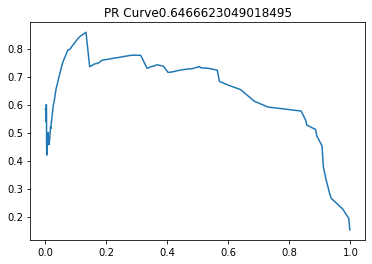

(3000,)
(33000,) (33000,)
AUC : 0.6492 


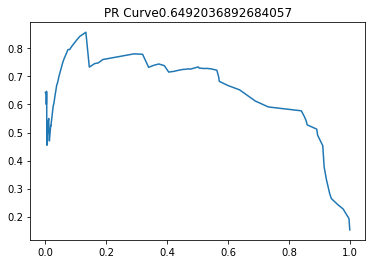

(3000,)
(33000,) (33000,)
AUC : 0.6475 


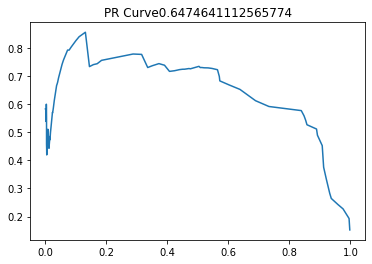

 Mean AUC  0.6477767018089442
 AUC std 0.0010607994672936463


In [19]:
test(
    dagmm_obj,
    data_dict
)